In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from snownlp import SnowNLP
import os
import glob

In [2]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 一、数据导入与描述

## 1、数据导入

In [4]:
# 文件路径
data_folder = "D:/360安全浏览器下载/"

# 读取训练和测试数据
train_price = pd.read_csv(f"{data_folder}ruc_Class25Q2_train_price.csv")
test_price = pd.read_csv(f"{data_folder}ruc_Class25Q2_test_price.csv")
train_rent = pd.read_csv(f"{data_folder}ruc_Class25Q2_train_rent.csv")
test_rent = pd.read_csv(f"{data_folder}ruc_Class25Q2_test_rent.csv")

In [5]:
# 查看每个数据集的基本信息
datasets = {
    "训练价格数据": train_price,
    "测试价格数据": test_price, 
    "训练租金数据": train_rent,
    "测试租金数据": test_rent
}

In [6]:
for name, data in datasets.items():
    print(f"\n{name}:")
    print(f"  形状: {data.shape}")
    print(f"  列名: {list(data.columns)}")


训练价格数据:
  形状: (103871, 55)
  列名: ['城市', '区域', '板块', '环线', 'Price', '房屋户型', '所在楼层', '建筑面积', '套内面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属', '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息', '房屋优势', '核心卖点', '户型介绍', '周边配套', '交通出行', 'lon', 'lat', '年份', '区县', '板块_comm', '环线位置', '物业类别', '建筑年代', '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构_comm', '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用', 'coord_x', 'coord_y', '客户反馈']

测试价格数据:
  形状: (34017, 55)
  列名: ['ID', '城市', '区域', '板块', '环线', '房屋户型', '所在楼层', '建筑面积', '套内面积', '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属', '上次交易', '房屋用途', '房屋年限', '产权所属', '抵押信息', '房屋优势', '核心卖点', '户型介绍', '周边配套', '交通出行', 'lon', 'lat', '年份', '区县', '板块_comm', '环线位置', '物业类别', '建筑年代', '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构_comm', '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用', 'coord_x', 'coord_y', '客户反馈']

训练租金数据:
  形状: (98899, 46)
  列名: ['城市', '户型', '装修', 'Price', '

## 2、训练集划分

In [7]:
# 划分价格训练集
price_train, price_val = train_test_split(train_price, test_size=0.2, random_state=111)
print(f"价格数据划分: 训练集 {price_train.shape}, 验证集 {price_val.shape}")

# 划分租金训练集  
rent_train, rent_val = train_test_split(train_rent, test_size=0.2, random_state=111)
print(f"租金数据划分: 训练集 {rent_train.shape}, 验证集 {rent_val.shape}")

价格数据划分: 训练集 (83096, 55), 验证集 (20775, 55)
租金数据划分: 训练集 (79119, 46), 验证集 (19780, 46)


## 3、描述性统计

In [8]:
train_datasets = {
    "价格价格集": price_train,
    "租金训练集": rent_train
}

In [9]:
def describe_data(df, df_name):
    """描述性统计函数"""
    print(f"\n数据集形状: {df.shape}")
    
    # 数值列描述性统计
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\n数值列描述性统计 (共{len(numeric_cols)}个数值列):")
        print(df[numeric_cols].describe())
    
    # 分类列基本信息
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"\n分类列基本信息 (共{len(categorical_cols)}个分类列，显示前10个):")
        for col in categorical_cols[:10]:
            unique_count = df[col].nunique()
            most_common = df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'
            print(f"  {col}: {unique_count}个唯一值, 最常见值: '{most_common}'")

describe_data(price_train, "价格训练集")
describe_data(rent_train, "租金训练集")


数据集形状: (83096, 55)

数值列描述性统计 (共14个数值列):
                 城市            区域            板块         Price  抵押信息  \
count  83096.000000  83096.000000  83096.000000  8.309600e+04   0.0   
mean       3.809257     65.573770    604.412547  2.269479e+06   NaN   
std        3.354199     33.746916    335.543253  2.543928e+06   NaN   
min        0.000000      3.000000      1.000000  7.455330e+04   NaN   
25%        2.000000     35.000000    314.000000  8.912602e+05   NaN   
50%        3.000000     68.000000    602.000000  1.484752e+06   NaN   
75%        6.000000     88.000000    909.000000  2.682339e+06   NaN   
max       11.000000    131.000000   1186.000000  5.622643e+07   NaN   

                lon           lat           年份            区县       板块_comm  \
count  83096.000000  83096.000000  83096.00000  77329.000000  77071.000000   
mean     114.807281     32.207532   2020.91239     65.869725    595.793904   
std        5.832636      5.961329      0.84715     33.876616    331.927077   
min    

# 二、数据预处理

## (一) 房价数据

### 1、删除有数据泄露的列

In [10]:
columns_to_drop = ['核心卖点']
price_train = price_train.drop(columns=columns_to_drop, errors='ignore')
price_val = price_val.drop(columns=columns_to_drop, errors='ignore')
test_price = test_price.drop(columns=columns_to_drop, errors='ignore')

### 2、空值处理

#### (1) 空值查看

In [11]:
def check_missing_values(df, df_name):
    """统计每个列的空值"""
    
    # 计算缺失值
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    # 创建缺失值统计表
    missing_info = pd.DataFrame({
        '缺失数量': missing,
        '缺失比例%': missing_pct
    }).sort_values('缺失比例%', ascending=False)
    
    # 只显示有缺失值的列
    missing_info = missing_info[missing_info['缺失数量'] > 0]
    
    if len(missing_info) > 0:
        print(f"\n有缺失值的列 (共{len(missing_info)}列):")
        print(missing_info)
    else:
        print("没有缺失值！")

In [12]:
check_missing_values(price_train, "训练价格数据")


有缺失值的列 (共40列):
            缺失数量       缺失比例%
抵押信息       83096  100.000000
别墅类型       81947   98.617262
环线位置       60486   72.790507
户型介绍       60016   72.224897
供暖         58190   70.027438
供热费        57837   69.602628
物业办公电话     55106   66.316068
套内面积       54355   65.412294
环线         50636   60.936748
房屋年限       35616   42.861269
交通出行       34748   41.816694
周边配套       34512   41.532685
物业公司       30270   36.427746
开发商        28881   34.756186
停车费用       28358   34.126793
建筑年代       27992   33.686339
停车位        27616   33.233850
容 积 率      26473   31.858333
绿 化 率      26280   31.626071
燃气费        26124   31.438336
物 业 费      24870   29.929238
供水         24179   29.097670
供电         24176   29.094060
建筑结构_comm  23242   27.970059
产权描述       22683   27.297343
物业类别       22683   27.297343
上次交易       20382   24.528256
房屋优势       17022   20.484741
配备电梯        9866   11.873014
板块_comm     6025    7.250650
区县          5767    6.940166
房屋总数        5677    6.831857
coord_y     5677    6.83185

In [13]:
check_missing_values(price_val, "验证价格数据")


有缺失值的列 (共40列):
            缺失数量       缺失比例%
抵押信息       20775  100.000000
别墅类型       20481   98.584838
环线位置       15288   73.588448
户型介绍       15084   72.606498
供暖         14736   70.931408
供热费        14651   70.522262
物业办公电话     13829   66.565584
套内面积       13532   65.135981
环线         12816   61.689531
房屋年限        8894   42.811071
周边配套        8626   41.521059
交通出行        8516   40.991576
物业公司        7638   36.765343
开发商         7260   34.945848
停车费用        7195   34.632972
建筑年代        7109   34.219013
停车位         6952   33.463297
容 积 率       6681   32.158845
绿 化 率       6603   31.783394
燃气费         6577   31.658243
物 业 费       6288   30.267148
供水          6119   29.453670
供电          6116   29.439230
建筑结构_comm   5877   28.288809
产权描述        5730   27.581227
物业类别        5730   27.581227
上次交易        5067   24.389892
房屋优势        4214   20.283995
配备电梯        2485   11.961492
板块_comm     1553    7.475331
区县          1474    7.095066
房屋总数        1454    6.998797
coord_y     1454    6.99879

In [14]:
check_missing_values(test_price, "测试价格数据")


有缺失值的列 (共39列):
            缺失数量       缺失比例%
抵押信息       34017  100.000000
别墅类型       33863   99.547285
套内面积       24102   70.852809
户型介绍       24005   70.567657
供热费        23028   67.695564
物业办公电话     22593   66.416792
环线位置       20644   60.687303
供暖         18602   54.684422
环线         18340   53.914219
交通出行       15358   45.148014
周边配套       15031   44.186730
房屋年限       11296   33.206926
物业公司       10942   32.166270
开发商        10592   31.137372
停车费用        9922   29.167769
停车位         9571   28.135932
建筑年代        9406   27.650880
容 积 率       9303   27.348091
绿 化 率       9180   26.986507
燃气费         9157   26.918893
物 业 费       8489   24.955169
供水          8195   24.090896
供电          8177   24.037981
建筑结构_comm   7834   23.029662
产权描述        7533   22.144810
物业类别        7533   22.144810
上次交易        7241   21.286416
房屋优势        6379   18.752389
配备电梯        4092   12.029279
板块_comm     3812   11.206162
区县          3732   10.970985
房屋总数        3715   10.921010
coord_y     3715   10.92101

In [15]:
# 删除全为空的列
columns_to_drop = ['抵押信息']
price_train = price_train.drop(columns=columns_to_drop, errors='ignore')
price_val = price_val.drop(columns=columns_to_drop, errors='ignore')
test_price = test_price.drop(columns=columns_to_drop, errors='ignore')

In [16]:
# 删除缺失值过高的列
columns_to_drop = ['抵押信息', '房屋年限', '户型介绍']
price_train = price_train.drop(columns=columns_to_drop, errors='ignore')
price_val = price_val.drop(columns=columns_to_drop, errors='ignore')
test_price = test_price.drop(columns=columns_to_drop, errors='ignore')

In [17]:
# 删除重复列
columns_to_drop = ['coord_y', 'coord_x', '区县', '板块_comm', '环线位置']
price_train = price_train.drop(columns=columns_to_drop, errors='ignore')
price_val = price_val.drop(columns=columns_to_drop, errors='ignore')
test_price = test_price.drop(columns=columns_to_drop, errors='ignore')

In [18]:
# 删除暂时不处理的列
columns_to_drop = ['城市', '板块', '环线', '房屋户型', '套内面积', '建筑结构_comm', '梯户比例', '别墅类型', '上次交易', '物业类别',
                   '建筑年代', '开发商', '物业公司', '物 业 费', '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费',
                   '停车位', '停车费用']
price_train = price_train.drop(columns=columns_to_drop, errors='ignore')
price_val = price_val.drop(columns=columns_to_drop, errors='ignore')
test_price = test_price.drop(columns=columns_to_drop, errors='ignore')

#### (2) 众数填充空值

In [19]:
def fill_with_mode(df, column_name, df_name=""):
    """用price_train训练集的众数填充指定列的空值"""
    if column_name in df.columns:
        # 使用price_train训练集数据的众数
        mode_value = price_train[column_name].mode()[0]
        missing_count = df[column_name].isna().sum()
        df[column_name] = df[column_name].fillna(mode_value)
        print(f"{df_name} {column_name} 列: 用训练集众数 '{mode_value}' 填充了 {missing_count} 个空值")
    else:
        print(f"列 '{column_name}' 不存在")
    return df

In [20]:
# 用于装修情况列
price_train = fill_with_mode(price_train, '装修情况')
price_val = fill_with_mode(price_val, '装修情况')
test_price = fill_with_mode(test_price, '装修情况')

装修情况 列: 用众数 '精装' 填充了 471 个空值
装修情况 列: 用众数 '精装' 填充了 109 个空值
装修情况 列: 用众数 '精装' 填充了 14 个空值


#### (3) 聚类填充空值

In [21]:
def fill_by_geography(df, column_name, df_name=""):
    """根据地理位置聚类填充指定列的缺失值（使用price_train训练集数据）"""
    
    print(f"\n开始处理 {df_name} 的 {column_name} 列:")
    
    # 始终使用price_train训练集数据作为参考
    df_with_value = price_train[price_train[column_name].notna() & 
                               (price_train[column_name] != '') & 
                               (price_train[column_name] != 'nan')].copy()
    
    # 当前数据集中需要填充的样本
    df_missing_value = df[df[column_name].isna() | (df[column_name] == '') | (df[column_name] == 'nan')].copy()
    
    if len(df_missing_value) == 0:
        print(f"{df_name} 的 {column_name} 列没有需要填充的缺失值")
        return df
    
    if len(df_with_value) == 0:
        print(f"警告: 训练集中没有可用的 {column_name} 数据")
        return df
    
    # 准备经纬度数据
    coords_with_value = df_with_value[['lon', 'lat']].values
    coords_missing = df_missing_value[['lon', 'lat']].values
    
    # 使用KNN找到最近的5个点
    knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
    knn.fit(coords_with_value)
    
    distances, indices = knn.kneighbors(coords_missing)
    
    # 填充缺失值
    filled_count = 0
    for i, (idx, missing_idx) in enumerate(zip(indices, df_missing_value.index)):
        # 获取训练集中最近5个点的值
        nearest_values = df_with_value.iloc[idx][column_name].values
        
        # 统计各个值的出现次数
        value_counts = {}
        for value in nearest_values:
            value_counts[value] = value_counts.get(value, 0) + 1
        
        # 选择出现次数最多的值
        most_common_value = max(value_counts.items(), key=lambda x: x[1])[0]
        
        # 输出前5个样本的填充信息
        if i < 5:
            print(f"{df_name} 样本 {missing_idx} 的最近5个训练集邻居{column_name}: {list(nearest_values)}")
            print(f"  {df_name} 填充为: {most_common_value}")
        
        # 填充数据
        df.loc[missing_idx, column_name] = most_common_value
        filled_count += 1
    
    print(f"{df_name} 的 {column_name} 列成功填充 {filled_count} 个缺失值（使用训练集数据）")
    return df

In [22]:
price_train = fill_by_geography(price_train, '房屋朝向', "训练价格数据")
price_val = fill_by_geography(price_val, '房屋朝向', "验证价格数据")
test_price = fill_by_geography(test_price, '房屋朝向', "测试价格数据")


开始处理 训练价格数据 的 房屋朝向 列:
训练价格数据 的 房屋朝向 列没有需要填充的缺失值

开始处理 验证价格数据 的 房屋朝向 列:
验证价格数据 样本 69397 的最近5个点房屋朝向: ['南', '南', '南', '南 北', '南']
  验证价格数据 填充为: 南
验证价格数据 的 房屋朝向 列成功填充 1 个缺失值

开始处理 测试价格数据 的 房屋朝向 列:
测试价格数据 的 房屋朝向 列没有需要填充的缺失值


In [23]:
price_train = fill_by_geography(price_train, '建筑结构', "训练价格数据")
price_val = fill_by_geography(price_val, '建筑结构', "验证价格数据")
test_price = fill_by_geography(test_price, '建筑结构', "测试价格数据")


开始处理 训练价格数据 的 建筑结构 列:
训练价格数据 样本 90033 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  训练价格数据 填充为: 钢混结构
训练价格数据 样本 101198 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  训练价格数据 填充为: 钢混结构
训练价格数据 样本 75962 的最近5个点建筑结构: ['钢混结构', '钢混结构', '框架结构', '框架结构', '框架结构']
  训练价格数据 填充为: 框架结构
训练价格数据 样本 75066 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  训练价格数据 填充为: 钢混结构
训练价格数据 样本 97248 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  训练价格数据 填充为: 钢混结构
训练价格数据 的 建筑结构 列成功填充 471 个缺失值

开始处理 验证价格数据 的 建筑结构 列:
验证价格数据 样本 92089 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  验证价格数据 填充为: 钢混结构
验证价格数据 样本 92477 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  验证价格数据 填充为: 钢混结构
验证价格数据 样本 89199 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  验证价格数据 填充为: 钢混结构
验证价格数据 样本 90231 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  验证价格数据 填充为: 钢混结构
验证价格数据 样本 91783 的最近5个点建筑结构: ['钢混结构', '钢混结构', '钢混结构', '钢混结构', '钢混结构']
  验证价格数据 填充为: 钢混结构
验证价格数据 的 建筑结构 列成功填充 109 个缺失值

开始处理 测试价格数据 的 

In [24]:
price_train = fill_by_geography(price_train, '房屋总数', "训练价格数据")
price_val = fill_by_geography(price_val, '房屋总数', "验证价格数据")
test_price = fill_by_geography(test_price, '房屋总数', "测试价格数据")


开始处理 训练价格数据 的 房屋总数 列:
训练价格数据 样本 87394 的最近5个点房屋总数: ['482户', '482户', '1597户', '1597户', '648户']
  训练价格数据 填充为: 482户
训练价格数据 样本 35918 的最近5个点房屋总数: ['1798户', '2559户', '2559户', '2559户', '2559户']
  训练价格数据 填充为: 2559户
训练价格数据 样本 77303 的最近5个点房屋总数: ['73户', '73户', '114户', '114户', '114户']
  训练价格数据 填充为: 114户
训练价格数据 样本 87939 的最近5个点房屋总数: ['482户', '482户', '1597户', '1597户', '648户']
  训练价格数据 填充为: 482户
训练价格数据 样本 20019 的最近5个点房屋总数: ['2092户', '2092户', '2092户', '2092户', '2092户']
  训练价格数据 填充为: 2092户
训练价格数据 的 房屋总数 列成功填充 5677 个缺失值

开始处理 验证价格数据 的 房屋总数 列:
验证价格数据 样本 34552 的最近5个点房屋总数: ['112户', '2700户', '2700户', '2700户', '2700户']
  验证价格数据 填充为: 2700户
验证价格数据 样本 43726 的最近5个点房屋总数: ['2700户', '2700户', '2700户', '2700户', '2700户']
  验证价格数据 填充为: 2700户
验证价格数据 样本 47404 的最近5个点房屋总数: ['948户', '465户', '465户', '465户', '465户']
  验证价格数据 填充为: 465户
验证价格数据 样本 98389 的最近5个点房屋总数: ['2368户', '2368户', '2368户', '2368户', '2368户']
  验证价格数据 填充为: 2368户
验证价格数据 样本 36305 的最近5个点房屋总数: ['180户', '180户', '180户', '180户', '180户']
  验证价格数据 填充为: 180户
验证价格数据 的 房屋总数

In [25]:
price_train = fill_by_geography(price_train, '楼栋总数', "训练价格数据")
price_val = fill_by_geography(price_val, '楼栋总数', "验证价格数据")
test_price = fill_by_geography(test_price, '楼栋总数', "测试价格数据")


开始处理 训练价格数据 的 楼栋总数 列:
训练价格数据 样本 87394 的最近5个点楼栋总数: ['9栋', '9栋', '8栋', '8栋', '1栋']
  训练价格数据 填充为: 9栋
训练价格数据 样本 35918 的最近5个点楼栋总数: ['11栋', '10栋', '10栋', '10栋', '10栋']
  训练价格数据 填充为: 10栋
训练价格数据 样本 77303 的最近5个点楼栋总数: ['3栋', '3栋', '2栋', '2栋', '2栋']
  训练价格数据 填充为: 2栋
训练价格数据 样本 87939 的最近5个点楼栋总数: ['9栋', '9栋', '8栋', '8栋', '1栋']
  训练价格数据 填充为: 9栋
训练价格数据 样本 20019 的最近5个点楼栋总数: ['14栋', '14栋', '14栋', '14栋', '14栋']
  训练价格数据 填充为: 14栋
训练价格数据 的 楼栋总数 列成功填充 5677 个缺失值

开始处理 验证价格数据 的 楼栋总数 列:
验证价格数据 样本 34552 的最近5个点楼栋总数: ['19栋', '53栋', '53栋', '53栋', '53栋']
  验证价格数据 填充为: 53栋
验证价格数据 样本 43726 的最近5个点楼栋总数: ['53栋', '53栋', '53栋', '53栋', '53栋']
  验证价格数据 填充为: 53栋
验证价格数据 样本 47404 的最近5个点楼栋总数: ['14栋', '3栋', '3栋', '3栋', '3栋']
  验证价格数据 填充为: 3栋
验证价格数据 样本 98389 的最近5个点楼栋总数: ['82栋', '82栋', '82栋', '82栋', '82栋']
  验证价格数据 填充为: 82栋
验证价格数据 样本 36305 的最近5个点楼栋总数: ['32栋', '32栋', '32栋', '32栋', '32栋']
  验证价格数据 填充为: 32栋
验证价格数据 的 楼栋总数 列成功填充 1454 个缺失值

开始处理 测试价格数据 的 楼栋总数 列:
测试价格数据 样本 26 的最近5个点楼栋总数: ['5栋', '5栋', '5栋', '5栋', '5栋']
  测试价格数据 填充为: 5栋
测

In [26]:
price_train = fill_by_geography(price_train, '绿 化 率', "训练价格数据")
price_val = fill_by_geography(price_val, '绿 化 率', "验证价格数据")
test_price = fill_by_geography(test_price, '绿 化 率', "测试价格数据")


开始处理 训练价格数据 的 绿 化 率 列:
训练价格数据 样本 53134 的最近5个点绿 化 率: ['30%', '30%', '30%', '30%', '30%']
  训练价格数据 填充为: 30%
训练价格数据 样本 48485 的最近5个点绿 化 率: ['35%', '35%', '40%', '40%', '40%']
  训练价格数据 填充为: 40%
训练价格数据 样本 67779 的最近5个点绿 化 率: ['37%', '37%', '37%', '47%', '41%']
  训练价格数据 填充为: 37%
训练价格数据 样本 62716 的最近5个点绿 化 率: ['35%', '35%', '35%', '35%', '35%']
  训练价格数据 填充为: 35%
训练价格数据 样本 87394 的最近5个点绿 化 率: ['30%', '30%', '30%', '30%', '35%']
  训练价格数据 填充为: 30%
训练价格数据 的 绿 化 率 列成功填充 26280 个缺失值

开始处理 验证价格数据 的 绿 化 率 列:
验证价格数据 样本 34552 的最近5个点绿 化 率: ['30%', '30%', '30%', '30%', '30%']
  验证价格数据 填充为: 30%
验证价格数据 样本 43726 的最近5个点绿 化 率: ['30%', '30%', '30%', '30%', '30%']
  验证价格数据 填充为: 30%
验证价格数据 样本 54452 的最近5个点绿 化 率: ['41%', '41%', '35%', '40%', '40%']
  验证价格数据 填充为: 41%
验证价格数据 样本 47404 的最近5个点绿 化 率: ['20%', '20%', '20%', '20%', '20%']
  验证价格数据 填充为: 20%
验证价格数据 样本 51280 的最近5个点绿 化 率: ['37.5%', '37.5%', '37.5%', '37.5%', '37.5%']
  验证价格数据 填充为: 37.5%
验证价格数据 的 绿 化 率 列成功填充 6603 个缺失值

开始处理 测试价格数据 的 绿 化 率 列:
测试价格数据 样本 26 的最近5个点绿 化 

In [27]:
price_train = fill_by_geography(price_train, '容 积 率', "训练价格数据")
price_val = fill_by_geography(price_val, '容 积 率', "验证价格数据")
test_price = fill_by_geography(test_price, '容 积 率', "测试价格数据")


开始处理 训练价格数据 的 容 积 率 列:
训练价格数据 样本 53134 的最近5个点容 积 率: [np.float64(1.89), np.float64(1.89), np.float64(1.89), np.float64(1.89), np.float64(1.89)]
  训练价格数据 填充为: 1.89
训练价格数据 样本 48485 的最近5个点容 积 率: [np.float64(0.43), np.float64(0.43), np.float64(0.43), np.float64(0.43), np.float64(0.43)]
  训练价格数据 填充为: 0.43
训练价格数据 样本 67779 的最近5个点容 积 率: [np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(1.0), np.float64(1.2)]
  训练价格数据 填充为: 2.0
训练价格数据 样本 62716 的最近5个点容 积 率: [np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0)]
  训练价格数据 填充为: 2.0
训练价格数据 样本 87394 的最近5个点容 积 率: [np.float64(2.0), np.float64(2.0), np.float64(2.9), np.float64(2.9), np.float64(2.9)]
  训练价格数据 填充为: 2.9
训练价格数据 的 容 积 率 列成功填充 26473 个缺失值

开始处理 验证价格数据 的 容 积 率 列:
验证价格数据 样本 34552 的最近5个点容 积 率: [np.float64(2.8), np.float64(2.8), np.float64(2.8), np.float64(2.8), np.float64(2.8)]
  验证价格数据 填充为: 2.8
验证价格数据 样本 43726 的最近5个点容 积 率: [np.float64(2.8), np.float64(2.8), np.float64(2.8), np.float64(2.8), np.float64(2

In [28]:
price_train = fill_by_geography(price_train, '配备电梯', "训练价格数据")
price_val = fill_by_geography(price_val, '配备电梯', "验证价格数据")
test_price = fill_by_geography(test_price, '配备电梯', "测试价格数据")


开始处理 训练价格数据 的 配备电梯 列:
训练价格数据 样本 20486 的最近5个点配备电梯: ['无', '无', '无', '无', '无']
  训练价格数据 填充为: 无
训练价格数据 样本 43718 的最近5个点配备电梯: ['有', '有', '有', '有', '有']
  训练价格数据 填充为: 有
训练价格数据 样本 27113 的最近5个点配备电梯: ['有', '有', '有', '有', '有']
  训练价格数据 填充为: 有
训练价格数据 样本 70844 的最近5个点配备电梯: ['无', '无', '无', '有', '无']
  训练价格数据 填充为: 无
训练价格数据 样本 62716 的最近5个点配备电梯: ['有', '有', '有', '有', '有']
  训练价格数据 填充为: 有
训练价格数据 的 配备电梯 列成功填充 9866 个缺失值

开始处理 验证价格数据 的 配备电梯 列:
验证价格数据 样本 47404 的最近5个点配备电梯: ['有', '有', '有', '有', '有']
  验证价格数据 填充为: 有
验证价格数据 样本 83939 的最近5个点配备电梯: ['有', '有', '有', '有', '有']
  验证价格数据 填充为: 有
验证价格数据 样本 42206 的最近5个点配备电梯: ['有', '有', '有', '有', '有']
  验证价格数据 填充为: 有
验证价格数据 样本 92089 的最近5个点配备电梯: ['有', '有', '有', '有', '有']
  验证价格数据 填充为: 有
验证价格数据 样本 62029 的最近5个点配备电梯: ['有', '无', '无', '有', '有']
  验证价格数据 填充为: 有
验证价格数据 的 配备电梯 列成功填充 2485 个缺失值

开始处理 测试价格数据 的 配备电梯 列:
测试价格数据 样本 5 的最近5个点配备电梯: ['无', '无', '无', '无', '无']
  测试价格数据 填充为: 无
测试价格数据 样本 8 的最近5个点配备电梯: ['有', '有', '有', '有', '有']
  测试价格数据 填充为: 有
测试价格数据 样本 18 的最近5个点配备电梯: ['无', '有', '有'

## (二) 租金数据

### 1、空值处理

#### (1) 空值查看

In [29]:
check_missing_values(rent_train, "训练租金数据")


有缺失值的列 (共37列):
          缺失数量      缺失比例%
车位       59231  74.863181
装修       58699  74.190776
供热费      56031  70.818640
环线位置     55745  70.457159
采暖       51539  65.141117
供暖       48908  61.815746
物业办公电话   48581  61.402444
租期       37617  47.544838
配套设施     24355  30.782745
物业公司     22946  29.001883
开发商      21586  27.282954
建筑年代     20911  26.429808
停车费用     20768  26.249068
停车位      20352  25.723278
燃气费      20017  25.299865
绿 化 率    19499  24.645155
容 积 率    19246  24.325383
物 业 费    17717  22.392851
供电       16948  21.420898
供水       16943  21.414578
建筑结构     16561  20.931761
物业类别     16074  20.316233
产权描述     16074  20.316233
付款方式     14775  18.674402
用水       14157  17.893300
用电       13843  17.496429
板块        4111   5.195971
区县        3734   4.719473
楼栋总数      3701   4.677764
房屋总数      3701   4.677764
coord_y   3701   4.677764
coord_x   3701   4.677764
燃气        3658   4.623415
楼层           4   0.005056
电梯           4   0.005056
朝向           4   0.005056
户型           1   0.001

In [30]:
check_missing_values(rent_val, "验证租金数据")


有缺失值的列 (共35列):
          缺失数量      缺失比例%
车位       14904  75.348837
装修       14790  74.772497
供热费      14033  70.945399
环线位置     13918  70.364004
采暖       12948  65.460061
供暖       12296  62.163802
物业办公电话   12111  61.228514
租期        9316  47.098079
配套设施      6096  30.819009
物业公司      5807  29.357937
开发商       5398  27.290192
建筑年代      5238  26.481294
停车费用      5235  26.466127
停车位       5127  25.920121
燃气费       5040  25.480283
绿 化 率     4903  24.787664
容 积 率     4834  24.438827
物 业 费     4442  22.457027
供电        4252  21.496461
供水        4251  21.491405
建筑结构      4180  21.132457
物业类别      4050  20.475228
产权描述      4050  20.475228
付款方式      3648  18.442872
用水        3583  18.114257
用电        3481  17.598584
板块        1033   5.222447
区县         943   4.767442
楼栋总数       930   4.701719
房屋总数       930   4.701719
coord_y    930   4.701719
coord_x    930   4.701719
燃气         924   4.671385
楼层           1   0.005056
朝向           1   0.005056


In [31]:
check_missing_values(test_rent, "测试租金数据")


有缺失值的列 (共33列):
         缺失数量      缺失比例%
车位       7611  77.877827
供热费      7054  72.178451
环线位置     6962  71.237082
采暖       6560  67.123708
物业办公电话   6453  66.028855
供暖       6195  63.388929
租期       5175  52.952011
配套设施     3694  37.798015
物业公司     3479  35.598076
建筑年代     3381  34.595314
开发商      3303  33.797196
停车费用     3249  33.244654
燃气费      3142  32.149800
停车位      3115  31.873529
绿 化 率    3019  30.891231
容 积 率    2988  30.574030
物 业 费    2804  28.691292
供水       2762  28.261537
供电       2760  28.241072
建筑结构     2699  27.616904
装修       2682  27.442955
物业类别     2625  26.859716
产权描述     2625  26.859716
付款方式     2387  24.424435
用水       2273  23.257956
用电       2227  22.787271
板块        936   9.577407
区县        925   9.464852
楼栋总数      923   9.444388
房屋总数      923   9.444388
coord_y   923   9.444388
coord_x   923   9.444388
燃气        591   6.047273


In [32]:
# 删除缺失值过高的列
columns_to_drop = ['车位', '采暖', '供暖', '环线位置']
rent_train = rent_train.drop(columns=columns_to_drop, errors='ignore')
rent_val = rent_val.drop(columns=columns_to_drop, errors='ignore')
test_rent = test_rent.drop(columns=columns_to_drop, errors='ignore')

In [33]:
# 删除重复列
columns_to_drop = ['供水', '供电', 'coord_x', 'coord_y']
rent_train = rent_train.drop(columns=columns_to_drop, errors='ignore')
rent_val = rent_val.drop(columns=columns_to_drop, errors='ignore')
test_rent = test_rent.drop(columns=columns_to_drop, errors='ignore')

In [34]:
# 删除暂时不处理的列
columns_to_drop = ['城市', '户型', '装修', '租期', '板块', '物业类别', '建筑年代', '开发商', '物业公司', '物 业 费', '物业办公电话', '产权描述', 
                   '燃气费', '供热费', '配套设施', '停车费用']
rent_train = rent_train.drop(columns=columns_to_drop, errors='ignore')
rent_val = rent_val.drop(columns=columns_to_drop, errors='ignore')
test_rent = test_rent.drop(columns=columns_to_drop, errors='ignore')

#### (2) 聚类填充空值

In [ ]:
def fill_by_geography_rent(df, column_name, df_name=""):
    """根据地理位置聚类填充指定列的缺失值（使用rent_train训练集数据）"""
    
    print(f"\n开始处理 {df_name} 的 {column_name} 列:")
    
    # 始终使用rent_train训练集数据作为参考
    df_with_value = rent_train[rent_train[column_name].notna() & 
                               (rent_train[column_name] != '') & 
                               (rent_train[column_name] != 'nan')].copy()
    
    # 当前数据集中需要填充的样本
    df_missing_value = df[df[column_name].isna() | (df[column_name] == '') | (df[column_name] == 'nan')].copy()
    
    if len(df_missing_value) == 0:
        print(f"{df_name} 的 {column_name} 列没有需要填充的缺失值")
        return df
    
    if len(df_with_value) == 0:
        print(f"警告: 训练集中没有可用的 {column_name} 数据")
        return df
    
    # 准备经纬度数据
    coords_with_value = df_with_value[['lon', 'lat']].values
    coords_missing = df_missing_value[['lon', 'lat']].values
    
    # 使用KNN找到最近的5个点
    knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
    knn.fit(coords_with_value)
    
    distances, indices = knn.kneighbors(coords_missing)
    
    # 填充缺失值
    filled_count = 0
    for i, (idx, missing_idx) in enumerate(zip(indices, df_missing_value.index)):
        # 获取训练集中最近5个点的值
        nearest_values = df_with_value.iloc[idx][column_name].values
        
        # 统计各个值的出现次数
        value_counts = {}
        for value in nearest_values:
            value_counts[value] = value_counts.get(value, 0) + 1
        
        # 选择出现次数最多的值
        most_common_value = max(value_counts.items(), key=lambda x: x[1])[0]
        
        # 输出前5个样本的填充信息
        if i < 5:
            print(f"{df_name} 样本 {missing_idx} 的最近5个训练集邻居{column_name}: {list(nearest_values)}")
            print(f"  {df_name} 填充为: {most_common_value}")
        
        # 填充数据
        df.loc[missing_idx, column_name] = most_common_value
        filled_count += 1
    
    print(f"{df_name} 的 {column_name} 列成功填充 {filled_count} 个缺失值（使用训练集数据）")
    return df

In [35]:
rent_train = fill_by_geography_rent(rent_train, '区县', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '区县', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '区县', "测试租金数据")


开始处理 训练租金数据 的 区县 列:
训练租金数据 样本 24070 的最近5个点区县: [np.float64(86.0), np.float64(86.0), np.float64(86.0), np.float64(86.0), np.float64(86.0)]
  训练租金数据 填充为: 86.0
训练租金数据 样本 84539 的最近5个点区县: [np.float64(106.0), np.float64(101.0), np.float64(101.0), np.float64(101.0), np.float64(101.0)]
  训练租金数据 填充为: 101.0
训练租金数据 样本 85193 的最近5个点区县: [np.float64(106.0), np.float64(101.0), np.float64(101.0), np.float64(101.0), np.float64(101.0)]
  训练租金数据 填充为: 101.0
训练租金数据 样本 18019 的最近5个点区县: [np.float64(88.0), np.float64(88.0), np.float64(88.0), np.float64(88.0), np.float64(88.0)]
  训练租金数据 填充为: 88.0
训练租金数据 样本 19941 的最近5个点区县: [np.float64(88.0), np.float64(88.0), np.float64(88.0), np.float64(88.0), np.float64(88.0)]
  训练租金数据 填充为: 88.0
训练租金数据 的 区县 列成功填充 3734 个缺失值

开始处理 验证租金数据 的 区县 列:
验证租金数据 样本 19533 的最近5个点区县: [np.float64(88.0), np.float64(88.0), np.float64(88.0), np.float64(88.0), np.float64(88.0)]
  验证租金数据 填充为: 88.0
验证租金数据 样本 26590 的最近5个点区县: [np.float64(76.0), np.float64(86.0), np.float64(86.0), np.float64(86.0), np.

In [36]:
rent_train = fill_by_geography_rent(rent_train, '付款方式', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '付款方式', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '付款方式', "测试租金数据")


开始处理 训练租金数据 的 付款方式 列:
训练租金数据 样本 61913 的最近5个点付款方式: ['月付价', '年付价', '月付价', '月付价', '月付价']
  训练租金数据 填充为: 月付价
训练租金数据 样本 3691 的最近5个点付款方式: ['季付价', '季付价', '季付价', '季付价', '季付价']
  训练租金数据 填充为: 季付价
训练租金数据 样本 17019 的最近5个点付款方式: ['季付价', '季付价', '季付价', '季付价', '季付价']
  训练租金数据 填充为: 季付价
训练租金数据 样本 16191 的最近5个点付款方式: ['季付价', '半年付价', '半年付价', '年付价', '年付价']
  训练租金数据 填充为: 半年付价
训练租金数据 样本 20378 的最近5个点付款方式: ['季付价', '半年付价', '季付价', '季付价', '季付价']
  训练租金数据 填充为: 季付价
训练租金数据 的 付款方式 列成功填充 14775 个缺失值

开始处理 验证租金数据 的 付款方式 列:
验证租金数据 样本 14904 的最近5个点付款方式: ['季付价', '季付价', '季付价', '季付价', '季付价']
  验证租金数据 填充为: 季付价
验证租金数据 样本 22261 的最近5个点付款方式: ['季付价', '季付价', '半年付价', '季付价', '季付价']
  验证租金数据 填充为: 季付价
验证租金数据 样本 82603 的最近5个点付款方式: ['半年付价', '半年付价', '半年付价', '半年付价', '半年付价']
  验证租金数据 填充为: 半年付价
验证租金数据 样本 21315 的最近5个点付款方式: ['季付价', '季付价', '季付价', '半年付价', '季付价']
  验证租金数据 填充为: 季付价
验证租金数据 样本 19533 的最近5个点付款方式: ['季付价', '季付价', '双月付价', '季付价', '年付价']
  验证租金数据 填充为: 季付价
验证租金数据 的 付款方式 列成功填充 3648 个缺失值

开始处理 测试租金数据 的 付款方式 列:
测试租金数据 样本 0 的最近5个点付款方式: ['季付价', '季付价',

In [37]:
rent_train = fill_by_geography_rent(rent_train, '用水', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '用水', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '用水', "测试租金数据")


开始处理 训练租金数据 的 用水 列:
训练租金数据 样本 61913 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  训练租金数据 填充为: 民水
训练租金数据 样本 24070 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  训练租金数据 填充为: 民水
训练租金数据 样本 17350 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  训练租金数据 填充为: 民水
训练租金数据 样本 94440 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  训练租金数据 填充为: 民水
训练租金数据 样本 80375 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  训练租金数据 填充为: 民水
训练租金数据 的 用水 列成功填充 14157 个缺失值

开始处理 验证租金数据 的 用水 列:
验证租金数据 样本 40805 的最近5个点用水: ['商水', '商水', '商水', '商水', '商水']
  验证租金数据 填充为: 商水
验证租金数据 样本 40832 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  验证租金数据 填充为: 民水
验证租金数据 样本 17323 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  验证租金数据 填充为: 民水
验证租金数据 样本 46234 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  验证租金数据 填充为: 民水
验证租金数据 样本 54657 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  验证租金数据 填充为: 民水
验证租金数据 的 用水 列成功填充 3583 个缺失值

开始处理 测试租金数据 的 用水 列:
测试租金数据 样本 2 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  测试租金数据 填充为: 民水
测试租金数据 样本 6 的最近5个点用水: ['民水', '民水', '民水', '民水', '民水']
  测试租金数据 填充为: 民水


In [38]:
rent_train = fill_by_geography_rent(rent_train, '用电', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '用电', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '用电', "测试租金数据")


开始处理 训练租金数据 的 用电 列:
训练租金数据 样本 61913 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  训练租金数据 填充为: 民电
训练租金数据 样本 24070 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  训练租金数据 填充为: 民电
训练租金数据 样本 17350 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  训练租金数据 填充为: 民电
训练租金数据 样本 94440 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  训练租金数据 填充为: 民电
训练租金数据 样本 80375 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  训练租金数据 填充为: 民电
训练租金数据 的 用电 列成功填充 13843 个缺失值

开始处理 验证租金数据 的 用电 列:
验证租金数据 样本 40832 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  验证租金数据 填充为: 民电
验证租金数据 样本 17323 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  验证租金数据 填充为: 民电
验证租金数据 样本 46234 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  验证租金数据 填充为: 民电
验证租金数据 样本 54657 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  验证租金数据 填充为: 民电
验证租金数据 样本 89866 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  验证租金数据 填充为: 民电
验证租金数据 的 用电 列成功填充 3481 个缺失值

开始处理 测试租金数据 的 用电 列:
测试租金数据 样本 2 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  测试租金数据 填充为: 民电
测试租金数据 样本 8 的最近5个点用电: ['民电', '民电', '民电', '民电', '民电']
  测试租金数据 填充为: 民电


In [39]:
rent_train = fill_by_geography_rent(rent_train, '燃气', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '燃气', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '燃气', "测试租金数据")


开始处理 训练租金数据 的 燃气 列:
训练租金数据 样本 80375 的最近5个点燃气: ['有', '有', '有', '有', '有']
  训练租金数据 填充为: 有
训练租金数据 样本 49444 的最近5个点燃气: ['有', '有', '有', '有', '有']
  训练租金数据 填充为: 有
训练租金数据 样本 82672 的最近5个点燃气: ['有', '无', '无', '有', '有']
  训练租金数据 填充为: 有
训练租金数据 样本 84539 的最近5个点燃气: ['有', '有', '有', '有', '有']
  训练租金数据 填充为: 有
训练租金数据 样本 77807 的最近5个点燃气: ['有', '有', '有', '有', '有']
  训练租金数据 填充为: 有
训练租金数据 的 燃气 列成功填充 3658 个缺失值

开始处理 验证租金数据 的 燃气 列:
验证租金数据 样本 54657 的最近5个点燃气: ['有', '无', '无', '无', '无']
  验证租金数据 填充为: 无
验证租金数据 样本 89866 的最近5个点燃气: ['无', '无', '有', '有', '无']
  验证租金数据 填充为: 无
验证租金数据 样本 81065 的最近5个点燃气: ['有', '有', '有', '无', '有']
  验证租金数据 填充为: 有
验证租金数据 样本 77852 的最近5个点燃气: ['有', '有', '有', '有', '有']
  验证租金数据 填充为: 有
验证租金数据 样本 9472 的最近5个点燃气: ['有', '有', '有', '有', '有']
  验证租金数据 填充为: 有
验证租金数据 的 燃气 列成功填充 924 个缺失值

开始处理 测试租金数据 的 燃气 列:
测试租金数据 样本 8 的最近5个点燃气: ['有', '有', '有', '有', '有']
  测试租金数据 填充为: 有
测试租金数据 样本 24 的最近5个点燃气: ['无', '有', '有', '有', '有']
  测试租金数据 填充为: 有
测试租金数据 样本 165 的最近5个点燃气: ['有', '有', '有', '有', '无']
  测试租金数据 填充为: 有
测试租金数据 样

In [40]:
rent_train = fill_by_geography_rent(rent_train, '绿 化 率', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '绿 化 率', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '绿 化 率', "测试租金数据")


开始处理 训练租金数据 的 绿 化 率 列:
训练租金数据 样本 35080 的最近5个点绿 化 率: ['41%', '41%', '37%', '37%', '37%']
  训练租金数据 填充为: 37%
训练租金数据 样本 24070 的最近5个点绿 化 率: ['30%', '30%', '30%', '35%', '35%']
  训练租金数据 填充为: 30%
训练租金数据 样本 78677 的最近5个点绿 化 率: ['49.51%', '25%', '49.51%', '49.51%', '25%']
  训练租金数据 填充为: 49.51%
训练租金数据 样本 49444 的最近5个点绿 化 率: ['35%', '35%', '35%', '35%', '35%']
  训练租金数据 填充为: 35%
训练租金数据 样本 82672 的最近5个点绿 化 率: ['40%', '45%', '45%', '45%', '45%']
  训练租金数据 填充为: 45%
训练租金数据 的 绿 化 率 列成功填充 19499 个缺失值

开始处理 验证租金数据 的 绿 化 率 列:
验证租金数据 样本 40805 的最近5个点绿 化 率: ['37%', '37%', '47%', '36%', '36%']
  验证租金数据 填充为: 37%
验证租金数据 样本 40832 的最近5个点绿 化 率: ['37%', '37%', '47%', '36%', '36%']
  验证租金数据 填充为: 37%
验证租金数据 样本 46234 的最近5个点绿 化 率: ['35%', '30%', '47%', '37%', '37%']
  验证租金数据 填充为: 37%
验证租金数据 样本 54657 的最近5个点绿 化 率: ['30%', '30%', '30%', '30%', '30%']
  验证租金数据 填充为: 30%
验证租金数据 样本 47601 的最近5个点绿 化 率: ['37%', '37%', '36%', '36%', '35%']
  验证租金数据 填充为: 37%
验证租金数据 的 绿 化 率 列成功填充 4903 个缺失值

开始处理 测试租金数据 的 绿 化 率 列:
测试租金数据 样本 2 的最近5个点绿 化 率

In [41]:
rent_train = fill_by_geography_rent(rent_train, '容 积 率', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '容 积 率', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '容 积 率', "测试租金数据")


开始处理 训练租金数据 的 容 积 率 列:
训练租金数据 样本 35080 的最近5个点容 积 率: [np.float64(1.2), np.float64(1.2), np.float64(2.0), np.float64(2.0), np.float64(2.0)]
  训练租金数据 填充为: 2.0
训练租金数据 样本 24070 的最近5个点容 积 率: [np.float64(2.8), np.float64(2.8), np.float64(2.8), np.float64(1.8), np.float64(1.8)]
  训练租金数据 填充为: 2.8
训练租金数据 样本 78677 的最近5个点容 积 率: [np.float64(3.48), np.float64(3.8), np.float64(3.48), np.float64(3.48), np.float64(3.8)]
  训练租金数据 填充为: 3.48
训练租金数据 样本 49444 的最近5个点容 积 率: [np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0)]
  训练租金数据 填充为: 2.0
训练租金数据 样本 70652 的最近5个点容 积 率: [np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(3.0)]
  训练租金数据 填充为: 3.0
训练租金数据 的 容 积 率 列成功填充 19246 个缺失值

开始处理 验证租金数据 的 容 积 率 列:
验证租金数据 样本 40805 的最近5个点容 积 率: [np.float64(2.0), np.float64(2.0), np.float64(1.0), np.float64(1.59), np.float64(1.59)]
  验证租金数据 填充为: 2.0
验证租金数据 样本 40832 的最近5个点容 积 率: [np.float64(2.0), np.float64(2.0), np.float64(1.0), np.float64(1.59), np.float64(1.59)]

In [42]:
rent_train = fill_by_geography_rent(rent_train, '建筑结构', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '建筑结构', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '建筑结构', "测试租金数据")


开始处理 训练租金数据 的 建筑结构 列:
训练租金数据 样本 35080 的最近5个点建筑结构: ['板楼', '板楼', '板楼', '板楼', '板楼']
  训练租金数据 填充为: 板楼
训练租金数据 样本 24070 的最近5个点建筑结构: ['塔楼/板楼/塔板结合', '塔楼/板楼/塔板结合', '塔楼/板楼/塔板结合', '板楼', '板楼']
  训练租金数据 填充为: 塔楼/板楼/塔板结合
训练租金数据 样本 49444 的最近5个点建筑结构: ['塔楼/板楼', '塔楼/板楼', '塔楼/板楼', '塔楼/板楼', '塔楼/板楼']
  训练租金数据 填充为: 塔楼/板楼
训练租金数据 样本 38803 的最近5个点建筑结构: ['塔楼/板楼', '板楼', '板楼/平房', '板楼/平房', '板楼/平房']
  训练租金数据 填充为: 板楼/平房
训练租金数据 样本 44972 的最近5个点建筑结构: ['塔楼/板楼', '塔楼/板楼', '塔楼/板楼', '塔楼/板楼', '塔楼/板楼']
  训练租金数据 填充为: 塔楼/板楼
训练租金数据 的 建筑结构 列成功填充 16561 个缺失值

开始处理 验证租金数据 的 建筑结构 列:
验证租金数据 样本 40805 的最近5个点建筑结构: ['板楼', '板楼', '板楼', '板楼', '板楼']
  验证租金数据 填充为: 板楼
验证租金数据 样本 40832 的最近5个点建筑结构: ['板楼', '板楼', '板楼', '板楼', '板楼']
  验证租金数据 填充为: 板楼
验证租金数据 样本 46234 的最近5个点建筑结构: ['板楼', '塔楼/板楼', '板楼', '板楼', '板楼']
  验证租金数据 填充为: 板楼
验证租金数据 样本 47601 的最近5个点建筑结构: ['板楼', '板楼', '板楼', '板楼', '塔楼']
  验证租金数据 填充为: 板楼
验证租金数据 样本 43619 的最近5个点建筑结构: ['板楼', '板楼', '板楼', '板楼', '板楼']
  验证租金数据 填充为: 板楼
验证租金数据 的 建筑结构 列成功填充 4180 个缺失值

开始处理 测试租金数据 的 建筑结构 列:
测试租金数据 样本 2 的最近5个点建筑结构: 

In [43]:
rent_train = fill_by_geography_rent(rent_train, '停车位', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '停车位', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '停车位', "测试租金数据")


开始处理 训练租金数据 的 停车位 列:
训练租金数据 样本 35080 的最近5个点停车位: [np.float64(238.0), np.float64(238.0), np.float64(256.0), np.float64(256.0), np.float64(256.0)]
  训练租金数据 填充为: 256.0
训练租金数据 样本 1854 的最近5个点停车位: [np.float64(70.0), np.float64(70.0), np.float64(70.0), np.float64(210.0), np.float64(210.0)]
  训练租金数据 填充为: 70.0
训练租金数据 样本 24070 的最近5个点停车位: [np.float64(2926.0), np.float64(2926.0), np.float64(2926.0), np.float64(396.0), np.float64(396.0)]
  训练租金数据 填充为: 2926.0
训练租金数据 样本 78677 的最近5个点停车位: [np.float64(700.0), np.float64(700.0), np.float64(700.0), np.float64(700.0), np.float64(700.0)]
  训练租金数据 填充为: 700.0
训练租金数据 样本 7081 的最近5个点停车位: [np.float64(2820.0), np.float64(2820.0), np.float64(2820.0), np.float64(2820.0), np.float64(2820.0)]
  训练租金数据 填充为: 2820.0
训练租金数据 的 停车位 列成功填充 20352 个缺失值

开始处理 验证租金数据 的 停车位 列:
验证租金数据 样本 40805 的最近5个点停车位: [np.float64(256.0), np.float64(256.0), np.float64(183.0), np.float64(183.0), np.float64(378.0)]
  验证租金数据 填充为: 256.0
验证租金数据 样本 40832 的最近5个点停车位: [np.float64(256.0), np.float64(256.0)

In [44]:
rent_train = fill_by_geography_rent(rent_train, '楼栋总数', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '楼栋总数', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '楼栋总数', "测试租金数据")


开始处理 训练租金数据 的 楼栋总数 列:
训练租金数据 样本 24070 的最近5个点楼栋总数: ['53栋', '53栋', '53栋', '13栋', '13栋']
  训练租金数据 填充为: 53栋
训练租金数据 样本 84539 的最近5个点楼栋总数: ['9栋', '8栋', '8栋', '8栋', '8栋']
  训练租金数据 填充为: 8栋
训练租金数据 样本 85193 的最近5个点楼栋总数: ['9栋', '8栋', '8栋', '8栋', '8栋']
  训练租金数据 填充为: 8栋
训练租金数据 样本 18019 的最近5个点楼栋总数: ['14栋', '14栋', '14栋', '14栋', '14栋']
  训练租金数据 填充为: 14栋
训练租金数据 样本 19941 的最近5个点楼栋总数: ['15栋', '15栋', '15栋', '15栋', '15栋']
  训练租金数据 填充为: 15栋
训练租金数据 的 楼栋总数 列成功填充 3701 个缺失值

开始处理 验证租金数据 的 楼栋总数 列:
验证租金数据 样本 19533 的最近5个点楼栋总数: ['14栋', '14栋', '14栋', '14栋', '14栋']
  验证租金数据 填充为: 14栋
验证租金数据 样本 26590 的最近5个点楼栋总数: ['1栋', '3栋', '3栋', '3栋', '3栋']
  验证租金数据 填充为: 3栋
验证租金数据 样本 81065 的最近5个点楼栋总数: ['11栋', '11栋', '3栋', '3栋', '2栋']
  验证租金数据 填充为: 11栋
验证租金数据 样本 20394 的最近5个点楼栋总数: ['14栋', '14栋', '14栋', '14栋', '14栋']
  验证租金数据 填充为: 14栋
验证租金数据 样本 66032 的最近5个点楼栋总数: ['4栋', '4栋', '4栋', '4栋', '4栋']
  验证租金数据 填充为: 4栋
验证租金数据 的 楼栋总数 列成功填充 930 个缺失值

开始处理 测试租金数据 的 楼栋总数 列:
测试租金数据 样本 6 的最近5个点楼栋总数: ['9栋', '8栋', '8栋', '8栋', '8栋']
  测试租金数据 填充为: 8栋
测试租金数据 

In [45]:
rent_train = fill_by_geography_rent(rent_train, '房屋总数', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '房屋总数', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '房屋总数', "测试租金数据")


开始处理 训练租金数据 的 房屋总数 列:
训练租金数据 样本 24070 的最近5个点房屋总数: ['2700户', '2700户', '2700户', '294户', '294户']
  训练租金数据 填充为: 2700户
训练租金数据 样本 84539 的最近5个点房屋总数: ['482户', '1597户', '1597户', '1597户', '1597户']
  训练租金数据 填充为: 1597户
训练租金数据 样本 85193 的最近5个点房屋总数: ['482户', '1597户', '1597户', '1597户', '1597户']
  训练租金数据 填充为: 1597户
训练租金数据 样本 18019 的最近5个点房屋总数: ['2092户', '2092户', '2092户', '2092户', '2092户']
  训练租金数据 填充为: 2092户
训练租金数据 样本 19941 的最近5个点房屋总数: ['3359户', '3359户', '3359户', '3359户', '3359户']
  训练租金数据 填充为: 3359户
训练租金数据 的 房屋总数 列成功填充 3701 个缺失值

开始处理 验证租金数据 的 房屋总数 列:
验证租金数据 样本 19533 的最近5个点房屋总数: ['2092户', '2092户', '2092户', '2092户', '2092户']
  验证租金数据 填充为: 2092户
验证租金数据 样本 26590 的最近5个点房屋总数: ['272户', '426户', '426户', '426户', '426户']
  验证租金数据 填充为: 426户
验证租金数据 样本 81065 的最近5个点房屋总数: ['141户', '141户', '500户', '500户', '2户']
  验证租金数据 填充为: 141户
验证租金数据 样本 20394 的最近5个点房屋总数: ['2092户', '2092户', '2092户', '2092户', '2092户']
  验证租金数据 填充为: 2092户
验证租金数据 样本 66032 的最近5个点房屋总数: ['381户', '381户', '381户', '381户', '381户']
  验证租金数据 填充为: 381户
验证租金数据 的

# 三、特征工程

## (一) 房价数据

### 1、构建虚拟变量

In [46]:
def count_categories(df, column_name):
    """统计类别变量每个类别的个数"""
    if column_name in df.columns:
        value_counts = df[column_name].value_counts()
        print(f"{column_name} 类别统计:")
        for value, count in value_counts.items():
            print(f"  '{value}': {count}个 ({count/len(df)*100:.2f}%)")
        print(f"总计: {len(value_counts)}个类别")
    else:
        print(f"列 '{column_name}' 不存在")

In [47]:
def create_dummies(df, columns):
    """为指定列创建哑变量"""
    for col in columns:
        if col in df.columns:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col])
            print(f"已为 {col} 创建 {dummies.shape[1]} 个哑变量")
    return df

In [48]:
count_categories(price_train, '区域')

区域 类别统计:
  '64.0': 5500个 (6.62%)
  '86.0': 5249个 (6.32%)
  '78.0': 3990个 (4.80%)
  '68.0': 3755个 (4.52%)
  '90.0': 2710个 (3.26%)
  '88.0': 2683个 (3.23%)
  '20.0': 2488个 (2.99%)
  '16.0': 2289个 (2.75%)
  '76.0': 2093个 (2.52%)
  '49.0': 1981个 (2.38%)
  '38.0': 1905个 (2.29%)
  '125.0': 1704个 (2.05%)
  '35.0': 1696个 (2.04%)
  '50.0': 1511个 (1.82%)
  '7.0': 1503个 (1.81%)
  '112.0': 1463个 (1.76%)
  '32.0': 1429个 (1.72%)
  '9.0': 1385个 (1.67%)
  '81.0': 1246个 (1.50%)
  '94.0': 1218个 (1.47%)
  '93.0': 1205个 (1.45%)
  '21.0': 1160个 (1.40%)
  '104.0': 1102个 (1.33%)
  '107.0': 1037个 (1.25%)
  '14.0': 1036个 (1.25%)
  '82.0': 1005个 (1.21%)
  '105.0': 984个 (1.18%)
  '24.0': 982个 (1.18%)
  '111.0': 935个 (1.13%)
  '28.0': 911个 (1.10%)
  '109.0': 905个 (1.09%)
  '10.0': 838个 (1.01%)
  '26.0': 804个 (0.97%)
  '17.0': 801个 (0.96%)
  '33.0': 799个 (0.96%)
  '65.0': 771个 (0.93%)
  '91.0': 749个 (0.90%)
  '18.0': 717个 (0.86%)
  '53.0': 697个 (0.84%)
  '80.0': 684个 (0.82%)
  '123.0': 684个 (0.82%)
  '30.0': 668个 (

In [49]:
# 创建哑变量
categorical_columns = ['区域']
price_train = create_dummies(price_train, categorical_columns)
price_val = create_dummies(price_val, categorical_columns)
test_price = create_dummies(test_price, categorical_columns)

已为 区域 创建 114 个哑变量
已为 区域 创建 110 个哑变量
已为 区域 创建 117 个哑变量


In [50]:
count_categories(price_train, '建筑结构')

建筑结构 类别统计:
  '钢混结构': 66446个 (79.96%)
  '混合结构': 7133个 (8.58%)
  '未知结构': 3837个 (4.62%)
  '砖混结构': 3406个 (4.10%)
  '框架结构': 1372个 (1.65%)
  '钢结构': 860个 (1.03%)
  '砖木结构': 42个 (0.05%)
总计: 7个类别


In [51]:
# 创建哑变量
categorical_columns = ['建筑结构']
price_train = create_dummies(price_train, categorical_columns)
price_val = create_dummies(price_val, categorical_columns)
test_price = create_dummies(test_price, categorical_columns)

已为 建筑结构 创建 6 个哑变量
已为 建筑结构 创建 6 个哑变量
已为 建筑结构 创建 6 个哑变量


In [52]:
count_categories(price_train, '装修情况')

装修情况 类别统计:
  '精装': 37714个 (45.39%)
  '其他': 19031个 (22.90%)
  '简装': 16496个 (19.85%)
  '毛坯': 9855个 (11.86%)
总计: 4个类别


In [53]:
# 创建哑变量
categorical_columns = ['装修情况']
price_train = create_dummies(price_train, categorical_columns)
price_val = create_dummies(price_val, categorical_columns)
test_price = create_dummies(test_price, categorical_columns)

已为 装修情况 创建 3 个哑变量
已为 装修情况 创建 3 个哑变量
已为 装修情况 创建 3 个哑变量


In [54]:
count_categories(price_train, '交易权属')

交易权属 类别统计:
  '商品房': 78612个 (94.60%)
  '已购公房': 1736个 (2.09%)
  '二类经济适用房': 434个 (0.52%)
  '动迁安置房': 422个 (0.51%)
  '房改房': 375个 (0.45%)
  '集资房': 368个 (0.44%)
  '一类经济适用房': 294个 (0.35%)
  '拆迁还建房': 242个 (0.29%)
  '经济适用房': 213个 (0.26%)
  '私产': 139个 (0.17%)
  '央产房': 128个 (0.15%)
  '限价商品房': 80个 (0.10%)
  '定向安置房': 39个 (0.05%)
  '售后公房': 13个 (0.02%)
  '回迁房': 1个 (0.00%)
总计: 15个类别


In [55]:
# 创建哑变量
categorical_columns = ['交易权属']
price_train = create_dummies(price_train, categorical_columns)
price_val = create_dummies(price_val, categorical_columns)
test_price = create_dummies(test_price, categorical_columns)

已为 交易权属 创建 14 个哑变量
已为 交易权属 创建 13 个哑变量
已为 交易权属 创建 14 个哑变量


In [56]:
count_categories(price_train, '房屋用途')

房屋用途 类别统计:
  '普通住宅': 76892个 (92.53%)
  '商住两用': 2426个 (2.92%)
  '别墅': 1612个 (1.94%)
  '商业办公类': 1229个 (1.48%)
  '车库': 471个 (0.57%)
  '公寓': 256个 (0.31%)
  '商务公寓': 116个 (0.14%)
  '酒店式公寓': 45个 (0.05%)
  '公寓/公寓': 12个 (0.01%)
  '新式里弄': 10个 (0.01%)
  '底商': 4个 (0.00%)
  '公寓/住宅': 4个 (0.00%)
  '商务型公寓': 4个 (0.00%)
  '老公寓': 3个 (0.00%)
  '四合院': 3个 (0.00%)
  '写字楼': 2个 (0.00%)
  '商业': 2个 (0.00%)
  '公寓（住宅）': 2个 (0.00%)
  '住宅式公寓': 1个 (0.00%)
  '花园洋房': 1个 (0.00%)
总计: 20个类别


In [57]:
# 创建哑变量
categorical_columns = ['房屋用途']
price_train = create_dummies(price_train, categorical_columns)
price_val = create_dummies(price_val, categorical_columns)
test_price = create_dummies(test_price, categorical_columns)

已为 房屋用途 创建 19 个哑变量
已为 房屋用途 创建 13 个哑变量
已为 房屋用途 创建 15 个哑变量


In [58]:
count_categories(price_train, '产权所属')

产权所属 类别统计:
  '非共有': 59013个 (71.02%)
  '共有': 24083个 (28.98%)
总计: 2个类别


In [59]:
# 创建哑变量
categorical_columns = ['产权所属']
price_train = create_dummies(price_train, categorical_columns)
price_val = create_dummies(price_val, categorical_columns)
test_price = create_dummies(test_price, categorical_columns)

已为 产权所属 创建 1 个哑变量
已为 产权所属 创建 1 个哑变量
已为 产权所属 创建 1 个哑变量


In [60]:
count_categories(price_train, '配备电梯')

配备电梯 类别统计:
  '有': 63769个 (76.74%)
  '无': 19327个 (23.26%)
总计: 2个类别


In [61]:
# 创建哑变量
categorical_columns = ['配备电梯']
price_train = create_dummies(price_train, categorical_columns)
price_val = create_dummies(price_val, categorical_columns)
test_price = create_dummies(test_price, categorical_columns)

已为 配备电梯 创建 1 个哑变量
已为 配备电梯 创建 1 个哑变量
已为 配备电梯 创建 1 个哑变量


### 2、文本变量信息提取

In [62]:
# 对房价的train和test数据提取楼层信息
price_train['楼层位置'] = price_train['所在楼层'].str.extract(r'^(.+?) \(')
price_train['总楼层数'] = price_train['所在楼层'].str.extract(r'共(\d+)层\)').astype(float)

price_val['楼层位置'] = price_val['所在楼层'].str.extract(r'^(.+?) \(')
price_val['总楼层数'] = price_val['所在楼层'].str.extract(r'共(\d+)层\)').astype(float)

test_price['楼层位置'] = test_price['所在楼层'].str.extract(r'^(.+?) \(')
test_price['总楼层数'] = test_price['所在楼层'].str.extract(r'共(\d+)层\)').astype(float)

# 查看提取结果
print("训练集楼层位置取值:", price_train['楼层位置'].unique())
print("训练集总楼层数范围:", price_train['总楼层数'].min(), "-", price_train['总楼层数'].max())
print("验证集楼层位置取值:", price_val['楼层位置'].unique())
print("验证集总楼层数范围:", price_val['总楼层数'].min(), "-", price_val['总楼层数'].max())
print("测试集楼层位置取值:", test_price['楼层位置'].unique())
print("测试集总楼层数范围:", test_price['总楼层数'].min(), "-", test_price['总楼层数'].max())

训练集楼层位置取值: ['中楼层' '低楼层' '高楼层' '底层' '顶层' '地下室']
训练集总楼层数范围: 0.0 - 70.0
验证集楼层位置取值: ['高楼层' '低楼层' '中楼层' '底层' '顶层' '地下室']
验证集总楼层数范围: 0.0 - 63.0
测试集楼层位置取值: ['中楼层' '高楼层' '顶层' '底层' '低楼层' '地下室']
测试集总楼层数范围: 0.0 - 58.0


In [63]:
# 创建哑变量
categorical_columns = ['楼层位置']
price_train = create_dummies(price_train, categorical_columns)
price_val = create_dummies(price_val, categorical_columns)
test_price = create_dummies(test_price, categorical_columns)

已为 楼层位置 创建 5 个哑变量
已为 楼层位置 创建 5 个哑变量
已为 楼层位置 创建 5 个哑变量


In [64]:
# 定义8个主要朝向
main_directions = ['东', '南', '西', '北', '东南', '东北', '西南', '西北']

# 为每个主要朝向创建哑变量
for direction in main_directions:
    price_train[f'朝向_{direction}'] = price_train['房屋朝向'].str.contains(direction).astype(int)
    price_val[f'朝向_{direction}'] = price_val['房屋朝向'].str.contains(direction).astype(int)
    test_price[f'朝向_{direction}'] = test_price['房屋朝向'].str.contains(direction).astype(int)

print("已创建8个朝向哑变量")

已创建8个朝向哑变量


In [65]:
# 处理混合格式的交易时间
def extract_year_month(date_str):
    """从日期字符串中提取年份和月份"""
    if '/' in str(date_str):
        parts = str(date_str).split('/')
        return int(parts[0]), int(parts[1])
    elif '-' in str(date_str):
        parts = str(date_str).split('-')
        return int(parts[0]), int(parts[1])
    else:
        return None, None

# 提取年份和月份
price_train['交易年份'] = price_train['交易时间'].apply(lambda x: extract_year_month(x)[0])
price_train['交易月份'] = price_train['交易时间'].apply(lambda x: extract_year_month(x)[1])

price_val['交易年份'] = price_val['交易时间'].apply(lambda x: extract_year_month(x)[0])
price_val['交易月份'] = price_val['交易时间'].apply(lambda x: extract_year_month(x)[1])

test_price['交易年份'] = test_price['交易时间'].apply(lambda x: extract_year_month(x)[0])
test_price['交易月份'] = test_price['交易时间'].apply(lambda x: extract_year_month(x)[1])

print(f"训练集年份范围: {price_train['交易年份'].min()} - {price_train['交易年份'].max()}")
print(f"训练集月份范围: {price_train['交易月份'].min()} - {price_train['交易月份'].max()}")

训练集年份范围: 2018 - 2025
训练集月份范围: 1 - 12


In [67]:
# 定义设施分类
facility_categories = {
    '交通设施': ['地铁', '公交', '交通', '号线', '路站'],
    '医疗资源': ['医院', '诊所', '医疗', '卫生院'],
    '教育资源': ['学校', '幼儿园', '小学', '中学', '大学', '学院'],
    '商业配套': ['超市', '商场', '购物', '百货', '广场', '市场', '菜市场'],
    '餐饮娱乐': ['饭店', '酒楼', '餐厅', '咖啡', '星巴克', '电影院', '健身'],
    '金融服务': ['银行', '工行', '农行', '建行', '中信', '邮政'],
    '公园绿地': ['公园', '绿地', '绿化', '园林']
}

In [68]:
# 将三列合并成一个文本再处理
price_train['综合配套'] = price_train['房屋优势'].fillna('') + ' ' + price_train['周边配套'].fillna('') + ' ' + price_train['交通出行'].fillna('')
price_val['综合配套'] = price_val['房屋优势'].fillna('') + ' ' + price_val['周边配套'].fillna('') + ' ' + price_val['交通出行'].fillna('')
test_price['综合配套'] = test_price['房屋优势'].fillna('') + ' ' + test_price['周边配套'].fillna('') + ' ' + test_price['交通出行'].fillna('')

# 对合并后的文本进行分类评分
for category, keywords in facility_categories.items():
    price_train[f'{category}'] = price_train['综合配套'].apply(
        lambda x: sum(1 for keyword in keywords if keyword in str(x))
    )
    price_val[f'{category}'] = price_val['综合配套'].apply(
        lambda x: sum(1 for keyword in keywords if keyword in str(x))
    )
    test_price[f'{category}'] = test_price['综合配套'].apply(
        lambda x: sum(1 for keyword in keywords if keyword in str(x))
    )

# 删除原始的三个文本列和临时列
columns_to_drop = ['房屋优势', '周边配套', '交通出行', '综合配套']
price_train = price_train.drop(columns=columns_to_drop, errors='ignore')
price_val = price_val.drop(columns=columns_to_drop, errors='ignore')
test_price = test_price.drop(columns=columns_to_drop, errors='ignore')

print("文本特征处理完成，已删除原始文本列")
print(f"新增特征: {[f'{category}_分数' for category in facility_categories.keys()]}")

文本特征处理完成，已删除原始文本列
新增特征: ['交通设施_分数', '医疗资源_分数', '教育资源_分数', '商业配套_分数', '餐饮娱乐_分数', '金融服务_分数', '公园绿地_分数']


In [69]:
def remove_unit_and_convert(df, column_name, unit):
    """去掉单位并转换为数值型"""
    if column_name in df.columns:
        df[column_name] = df[column_name].str.replace(unit, '').astype(float)
        print(f"{column_name}: 已去掉'{unit}'并转换为数值型")
    return df

In [70]:
# 处理房屋总数（去掉"户"）
price_train = remove_unit_and_convert(price_train, '房屋总数', '户')
price_val = remove_unit_and_convert(price_val, '房屋总数', '户')
test_price = remove_unit_and_convert(test_price, '房屋总数', '户')

房屋总数: 已去掉'户'并转换为数值型
房屋总数: 已去掉'户'并转换为数值型
房屋总数: 已去掉'户'并转换为数值型


In [71]:
# 处理楼栋总数（去掉"栋"）
price_train = remove_unit_and_convert(price_train, '楼栋总数', '栋')
price_val = remove_unit_and_convert(price_val, '楼栋总数', '栋')
test_price = remove_unit_and_convert(test_price, '楼栋总数', '栋')

楼栋总数: 已去掉'栋'并转换为数值型
楼栋总数: 已去掉'栋'并转换为数值型
楼栋总数: 已去掉'栋'并转换为数值型


In [72]:
# 建筑面积去掉单位，转换为数值型变量
price_train['建筑面积'] = price_train['建筑面积'].str.replace('㎡', '').astype(float)
price_val['建筑面积'] = price_val['建筑面积'].str.replace('㎡', '').astype(float)
test_price['建筑面积'] = test_price['建筑面积'].str.replace('㎡', '').astype(float)

# 验证转换结果
print("训练集建筑面积范围:", price_train['建筑面积'].min(), "-", price_train['建筑面积'].max())

训练集建筑面积范围: 11.7 - 508.11


In [73]:
# 绿化率去掉百分号，转换为数值型
price_train['绿 化 率'] = price_train['绿 化 率'].str.replace('%', '').astype(float) / 100
price_val['绿 化 率'] = price_val['绿 化 率'].str.replace('%', '').astype(float) / 100
test_price['绿 化 率'] = test_price['绿 化 率'].str.replace('%', '').astype(float) / 100

print(f"训练集绿化率范围: {price_train['绿 化 率'].min():.3f} - {price_train['绿 化 率'].max():.3f}")

训练集绿化率范围: 0.000 - 105.000


In [74]:
def sentiment_score(text):
    """计算文本情感得分（0-1，越接近1越积极）"""
    if pd.isna(text) or text == '':
        return np.nan
    try:
        return SnowNLP(str(text)).sentiments
    except:
        return np.nan

In [75]:
# 计算情感得分
price_train['客户反馈情感分'] = price_train['客户反馈'].apply(sentiment_score)
price_val['客户反馈情感分'] = price_val['客户反馈'].apply(sentiment_score)
test_price['客户反馈情感分'] = test_price['客户反馈'].apply(sentiment_score)

print(f"训练集情感分范围: {price_train['客户反馈情感分'].min():.3f} - {price_train['客户反馈情感分'].max():.3f}")
print(f"验证集情感分范围: {price_val['客户反馈情感分'].min():.3f} - {price_val['客户反馈情感分'].max():.3f}")
print(f"测试集情感分范围: {test_price['客户反馈情感分'].min():.3f} - {test_price['客户反馈情感分'].max():.3f}")

训练集情感分范围: 0.000 - 1.000
验证集情感分范围: 0.000 - 1.000
测试集情感分范围: 0.000 - 1.000


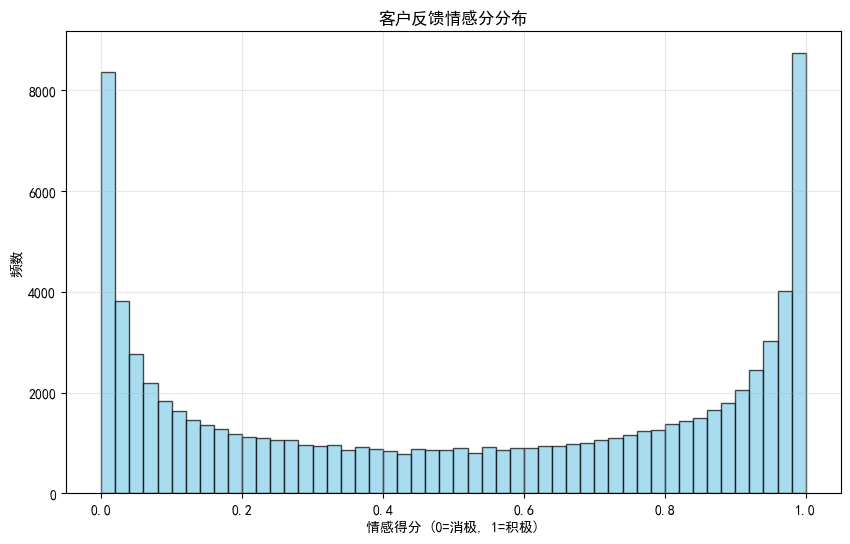

In [76]:
# 查看情感分布
plt.figure(figsize=(10, 6))
plt.hist(price_train['客户反馈情感分'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('客户反馈情感分分布')
plt.xlabel('情感得分 (0=消极, 1=积极)')
plt.ylabel('频数')
plt.grid(True, alpha=0.3)
plt.show()

In [77]:
# 删除原始的特征列
columns_to_drop = ['所在楼层', '房屋朝向', '交易时间', '客户反馈']
price_train = price_train.drop(columns=columns_to_drop, errors='ignore')
price_val = price_val.drop(columns=columns_to_drop, errors='ignore')
test_price = test_price.drop(columns=columns_to_drop, errors='ignore')

In [78]:
check_missing_values(price_train, "训练价格数据")

没有缺失值！


In [79]:
list(price_train.columns)

['Price',
 '建筑面积',
 'lon',
 'lat',
 '年份',
 '房屋总数',
 '楼栋总数',
 '绿 化 率',
 '容 积 率',
 '区域_4.0',
 '区域_5.0',
 '区域_7.0',
 '区域_8.0',
 '区域_9.0',
 '区域_10.0',
 '区域_11.0',
 '区域_12.0',
 '区域_13.0',
 '区域_14.0',
 '区域_15.0',
 '区域_16.0',
 '区域_17.0',
 '区域_18.0',
 '区域_19.0',
 '区域_20.0',
 '区域_21.0',
 '区域_22.0',
 '区域_23.0',
 '区域_24.0',
 '区域_26.0',
 '区域_27.0',
 '区域_28.0',
 '区域_29.0',
 '区域_30.0',
 '区域_31.0',
 '区域_32.0',
 '区域_33.0',
 '区域_34.0',
 '区域_35.0',
 '区域_36.0',
 '区域_37.0',
 '区域_38.0',
 '区域_41.0',
 '区域_42.0',
 '区域_43.0',
 '区域_44.0',
 '区域_45.0',
 '区域_46.0',
 '区域_47.0',
 '区域_49.0',
 '区域_50.0',
 '区域_51.0',
 '区域_52.0',
 '区域_53.0',
 '区域_54.0',
 '区域_55.0',
 '区域_56.0',
 '区域_57.0',
 '区域_58.0',
 '区域_59.0',
 '区域_60.0',
 '区域_62.0',
 '区域_63.0',
 '区域_64.0',
 '区域_65.0',
 '区域_66.0',
 '区域_67.0',
 '区域_68.0',
 '区域_69.0',
 '区域_70.0',
 '区域_71.0',
 '区域_72.0',
 '区域_73.0',
 '区域_74.0',
 '区域_76.0',
 '区域_77.0',
 '区域_78.0',
 '区域_80.0',
 '区域_81.0',
 '区域_82.0',
 '区域_84.0',
 '区域_85.0',
 '区域_86.0',
 '区域_87.0',
 '区域_88.0',
 '区域_89.0',
 

### 3、目标变量对数变换

In [80]:
# 创建对数变换后的新列，同时保留原始Price列
price_train['Price_log'] = np.log1p(price_train['Price'])
price_val['Price_log'] = np.log1p(price_val['Price'])

print(f"原始目标变量统计:")
print(f"  训练集: 均值={price_train['Price'].mean():.2f}, 标准差={price_train['Price'].std():.2f}")
print(f"  验证集: 均值={price_val['Price'].mean():.2f}, 标准差={price_val['Price'].std():.2f}")

print(f"对数变换后目标变量统计:")
print(f"  训练集: 均值={price_train['Price_log'].mean():.2f}, 标准差={price_train['Price_log'].std():.2f}")
print(f"  验证集: 均值={price_val['Price_log'].mean():.2f}, 标准差={price_val['Price_log'].std():.2f}")

原始目标变量统计:
  训练集: 均值=2269478.97, 标准差=2543927.63
  验证集: 均值=2233915.87, 标准差=2488289.34
对数变换后目标变量统计:
  训练集: 均值=14.26, 标准差=0.83
  验证集: 均值=14.26, 标准差=0.82


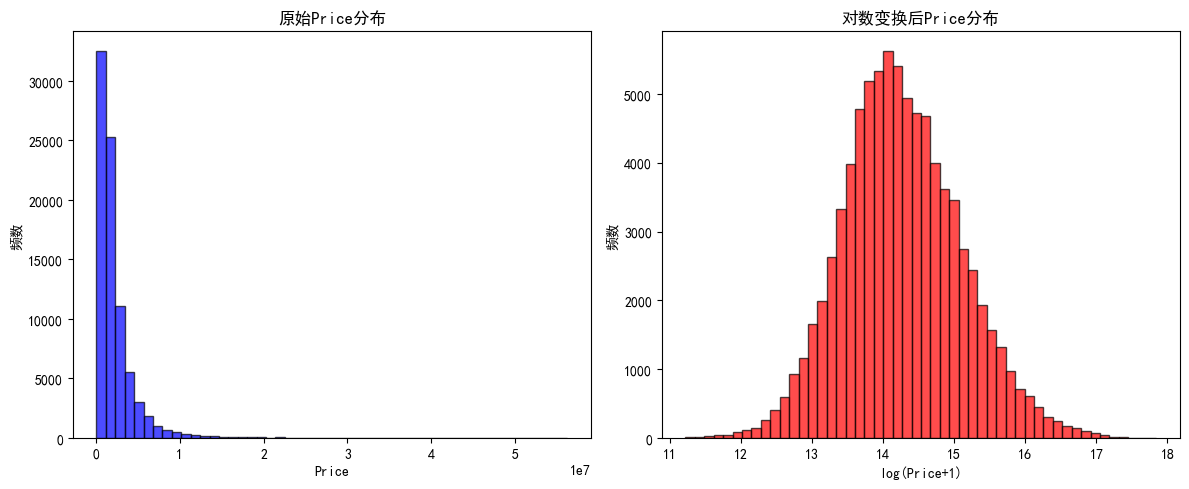

In [81]:
# 可视化对比
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(price_train['Price'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('原始Price分布')
plt.xlabel('Price')
plt.ylabel('频数')

plt.subplot(1, 2, 2)
plt.hist(price_train['Price_log'], bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('对数变换后Price分布')
plt.xlabel('log(Price+1)')
plt.ylabel('频数')

plt.tight_layout()
plt.show()

In [86]:
print(f"训练集形状: {price_train.shape}")
print(f"验证集形状: {price_val.shape}")
print(f"测试集形状: {test_price.shape}")

训练集形状: (83096, 192)
验证集形状: (20775, 181)
测试集形状: (34017, 190)


## (二) 租金数据

### 1、构建虚拟变量

In [87]:
count_categories(rent_train, '付款方式')

付款方式 类别统计:
  '季付价': 50722个 (64.11%)
  '月付价': 20045个 (25.34%)
  '半年付价': 6789个 (8.58%)
  '年付价': 1527个 (1.93%)
  '双月付价': 32个 (0.04%)
  'https://img.ljcdn.com/usercent': 2个 (0.00%)
  'https://image1.ljcdn.com/rent-': 2个 (0.00%)
总计: 7个类别


In [88]:
# 手动删除包含特定URL的行
def remove_url_rows(df, payment_col='付款方式'):
    """删除包含特定URL的行"""
    initial_count = len(df)
    
    # 定义要删除的URL模式
    url_patterns = [
        'https://img.ljcdn.com/usercent',
        'https://image1.ljcdn.com/rent-'
    ]
    
    # 创建掩码，标记要删除的行
    mask = df[payment_col].isin(url_patterns)
    rows_to_delete = mask.sum()
    
    # 删除这些行
    df_clean = df[~mask].copy()
    
    print(f"删除了 {rows_to_delete} 行包含URL的数据")
    print(f"删除前: {initial_count} 行")
    print(f"删除后: {len(df_clean)} 行")
    
    return df_clean

In [89]:
# 删除包含URL的行
print("删除包含URL的行...")
rent_train = remove_url_rows(rent_train, '付款方式')

删除包含URL的行...
删除了 4 行包含URL的数据
删除前: 79119 行
删除后: 79115 行


In [90]:
# 创建哑变量
categorical_columns = ['付款方式']
rent_train = create_dummies(rent_train, categorical_columns)
rent_val = create_dummies(rent_val, categorical_columns)
test_rent = create_dummies(test_rent, categorical_columns)

已为 付款方式 创建 4 个哑变量
已为 付款方式 创建 5 个哑变量
已为 付款方式 创建 4 个哑变量


In [91]:
count_categories(rent_train, '用水')

用水 类别统计:
  '民水': 71073个 (89.84%)
  '商水': 8042个 (10.16%)
总计: 2个类别


In [92]:
# 创建哑变量
categorical_columns = ['用水']
rent_train = create_dummies(rent_train, categorical_columns)
rent_val = create_dummies(rent_val, categorical_columns)
test_rent = create_dummies(test_rent, categorical_columns)

已为 用水 创建 1 个哑变量
已为 用水 创建 1 个哑变量
已为 用水 创建 1 个哑变量


In [93]:
count_categories(rent_train, '用电')

用电 类别统计:
  '民电': 71089个 (89.86%)
  '商电': 8026个 (10.14%)
总计: 2个类别


In [94]:
# 创建哑变量
categorical_columns = ['用电']
rent_train = create_dummies(rent_train, categorical_columns)
rent_val = create_dummies(rent_val, categorical_columns)
test_rent = create_dummies(test_rent, categorical_columns)

已为 用电 创建 1 个哑变量
已为 用电 创建 1 个哑变量
已为 用电 创建 1 个哑变量


In [95]:
count_categories(rent_train, '燃气')

燃气 类别统计:
  '有': 71246个 (90.05%)
  '无': 7869个 (9.95%)
总计: 2个类别


In [96]:
# 创建哑变量
categorical_columns = ['燃气']
rent_train = create_dummies(rent_train, categorical_columns)
rent_val = create_dummies(rent_val, categorical_columns)
test_rent = create_dummies(test_rent, categorical_columns)

已为 燃气 创建 1 个哑变量
已为 燃气 创建 1 个哑变量
已为 燃气 创建 1 个哑变量


In [97]:
count_categories(rent_train, '租赁方式')

租赁方式 类别统计:
  '整租': 74415个 (94.06%)
  '合租': 4700个 (5.94%)
总计: 2个类别


In [98]:
# 创建哑变量
categorical_columns = ['租赁方式']
rent_train = create_dummies(rent_train, categorical_columns)
rent_val = create_dummies(rent_val, categorical_columns)
test_rent = create_dummies(test_rent, categorical_columns)

已为 租赁方式 创建 1 个哑变量
已为 租赁方式 创建 1 个哑变量
已为 租赁方式 创建 1 个哑变量


In [99]:
count_categories(rent_train, '电梯')

电梯 类别统计:
  '有': 55409个 (70.04%)
  '无': 23702个 (29.96%)
总计: 2个类别


In [100]:
# 创建哑变量
categorical_columns = ['电梯']
rent_train = create_dummies(rent_train, categorical_columns)
rent_val = create_dummies(rent_val, categorical_columns)
test_rent = create_dummies(test_rent, categorical_columns)

已为 电梯 创建 1 个哑变量
已为 电梯 创建 1 个哑变量
已为 电梯 创建 1 个哑变量


In [101]:
count_categories(rent_train, '区县')

区县 类别统计:
  '64.0': 4723个 (5.97%)
  '68.0': 3361个 (4.25%)
  '88.0': 3292个 (4.16%)
  '38.0': 2924个 (3.70%)
  '86.0': 2685个 (3.39%)
  '125.0': 2247个 (2.84%)
  '15.0': 1988个 (2.51%)
  '81.0': 1983个 (2.51%)
  '131.0': 1969个 (2.49%)
  '32.0': 1938个 (2.45%)
  '78.0': 1843个 (2.33%)
  '80.0': 1664个 (2.10%)
  '76.0': 1611个 (2.04%)
  '99.0': 1556个 (1.97%)
  '17.0': 1407个 (1.78%)
  '49.0': 1347个 (1.70%)
  '90.0': 1307个 (1.65%)
  '26.0': 1304个 (1.65%)
  '7.0': 1252个 (1.58%)
  '20.0': 1225个 (1.55%)
  '112.0': 1210个 (1.53%)
  '102.0': 1187个 (1.50%)
  '16.0': 1105个 (1.40%)
  '101.0': 1057个 (1.34%)
  '120.0': 994个 (1.26%)
  '9.0': 984个 (1.24%)
  '51.0': 976个 (1.23%)
  '24.0': 957个 (1.21%)
  '93.0': 953个 (1.20%)
  '53.0': 915个 (1.16%)
  '82.0': 910个 (1.15%)
  '109.0': 908个 (1.15%)
  '94.0': 883个 (1.12%)
  '43.0': 864个 (1.09%)
  '67.0': 858个 (1.08%)
  '110.0': 855个 (1.08%)
  '91.0': 846个 (1.07%)
  '126.0': 824个 (1.04%)
  '58.0': 823个 (1.04%)
  '35.0': 788个 (1.00%)
  '111.0': 748个 (0.95%)
  '10.0': 740个 (

In [102]:
# 创建哑变量
categorical_columns = ['区县']
rent_train = create_dummies(rent_train, categorical_columns)
rent_val = create_dummies(rent_val, categorical_columns)
test_rent = create_dummies(test_rent, categorical_columns)

已为 区县 创建 102 个哑变量
已为 区县 创建 101 个哑变量
已为 区县 创建 102 个哑变量


In [103]:
count_categories(rent_train, '建筑结构')

建筑结构 类别统计:
  '板楼': 23096个 (29.19%)
  '塔楼': 16276个 (20.57%)
  '塔楼/板楼': 10153个 (12.83%)
  '塔楼/板楼/塔板结合': 8622个 (10.90%)
  '塔板结合': 6226个 (7.87%)
  '板楼/塔板结合': 5053个 (6.39%)
  '板楼/平房': 4015个 (5.07%)
  '塔楼/塔板结合': 3359个 (4.25%)
  '塔楼/板楼/塔板结合/平房': 868个 (1.10%)
  '塔楼/板楼/平房': 546个 (0.69%)
  '塔楼/平房': 329个 (0.42%)
  '板楼/塔板结合/平房': 278个 (0.35%)
  '塔板结合/平房': 158个 (0.20%)
  '平房': 136个 (0.17%)
总计: 14个类别


### 2、文本变量信息提取

In [104]:
def standardize_floor_format(df, floor_col='楼层'):
    """统一楼层格式为'楼层位置/总层数'格式"""
    def format_floor(floor_str):
        if pd.isna(floor_str):
            return floor_str
        
        floor_str = str(floor_str)
        
        # 如果已经是"楼层位置/总层数"格式，直接返回
        if '/' in floor_str and '层' in floor_str and not floor_str.startswith(('低', '中', '高', '顶', '底', '地下')):
            # 格式如"4/6层"，转换为"中楼层/6层"
            current_floor, total_floors = floor_str.replace('层', '').split('/')
            current_floor = int(current_floor)
            total_floors = int(total_floors)
            
            # 根据当前楼层确定楼层位置
            if current_floor == 1:
                floor_position = '底层'
            elif current_floor == total_floors:
                floor_position = '顶层'
            elif current_floor <= total_floors * 0.3:
                floor_position = '低楼层'
            elif current_floor <= total_floors * 0.7:
                floor_position = '中楼层'
            else:
                floor_position = '高楼层'
            
            return f"{floor_position}/{total_floors}层"
        
        # 如果已经是"楼层位置/总层数"格式，直接返回
        elif '/' in floor_str and any(floor_str.startswith(pos) for pos in ['低', '中', '高', '顶', '底', '地下']):
            return floor_str
        
        # 其他格式保持不变
        else:
            return floor_str
    
    df[floor_col] = df[floor_col].apply(format_floor)
    return df

In [105]:
# 统一租金数据的楼层格式
rent_train = standardize_floor_format(rent_train, '楼层')
rent_val = standardize_floor_format(rent_val, '楼层')
test_rent = standardize_floor_format(test_rent, '楼层')

In [106]:
# 对租金的train和test数据提取楼层信息
rent_train['楼层位置'] = rent_train['楼层'].str.extract(r'^(.+?)/')
rent_train['总楼层数'] = rent_train['楼层'].str.extract(r'/(\d+)层').astype(float)

rent_val['楼层位置'] = rent_val['楼层'].str.extract(r'^(.+?)/')
rent_val['总楼层数'] = rent_val['楼层'].str.extract(r'/(\d+)层').astype(float)

test_rent['楼层位置'] = test_rent['楼层'].str.extract(r'^(.+?)/')
test_rent['总楼层数'] = test_rent['楼层'].str.extract(r'/(\d+)层').astype(float)

# 查看提取结果
print("\n租金数据楼层信息提取结果:")
print("训练集楼层位置取值:", rent_train['楼层位置'].unique())
print("训练集总楼层数范围:", rent_train['总楼层数'].min(), "-", rent_train['总楼层数'].max())
print("验证集楼层位置取值:", rent_val['楼层位置'].unique())
print("验证集总楼层数范围:", rent_val['总楼层数'].min(), "-", rent_val['总楼层数'].max())
print("测试集楼层位置取值:", test_rent['楼层位置'].unique())
print("测试集总楼层数范围:", test_rent['总楼层数'].min(), "-", test_rent['总楼层数'].max())


租金数据楼层信息提取结果:
训练集楼层位置取值: ['中楼层' '高楼层' '低楼层' '顶层' '地下室' '底层' nan]
训练集总楼层数范围: 0.0 - 75.0
验证集楼层位置取值: ['中楼层' '高楼层' '低楼层' '地下室' '顶层' '底层' nan]
验证集总楼层数范围: 0.0 - 63.0
测试集楼层位置取值: ['低楼层' '中楼层' '高楼层' '顶层' '地下室' '底层']
测试集总楼层数范围: 0.0 - 58.0


In [107]:
rent_train = fill_by_geography_rent(rent_train, '楼层位置', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '楼层位置', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '楼层位置', "测试租金数据")


开始处理 训练租金数据 的 楼层位置 列:
训练租金数据 样本 1792 的最近5个点楼层位置: ['顶层', '中楼层', '中楼层', '中楼层', '低楼层']
  训练租金数据 填充为: 中楼层
训练租金数据 样本 14399 的最近5个点楼层位置: ['中楼层', '高楼层', '中楼层', '中楼层', '高楼层']
  训练租金数据 填充为: 中楼层
训练租金数据 样本 13094 的最近5个点楼层位置: ['高楼层', '中楼层', '中楼层', '中楼层', '高楼层']
  训练租金数据 填充为: 中楼层
训练租金数据 样本 11965 的最近5个点楼层位置: ['低楼层', '低楼层', '低楼层', '低楼层', '低楼层']
  训练租金数据 填充为: 低楼层
训练租金数据 样本 3373 的最近5个点楼层位置: ['高楼层', '低楼层', '高楼层', '中楼层', '中楼层']
  训练租金数据 填充为: 高楼层
训练租金数据 的 楼层位置 列成功填充 9 个缺失值

开始处理 验证租金数据 的 楼层位置 列:
验证租金数据 样本 28659 的最近5个点楼层位置: ['高楼层', '高楼层', '中楼层', '中楼层', '高楼层']
  验证租金数据 填充为: 高楼层
验证租金数据 样本 5682 的最近5个点楼层位置: ['中楼层', '高楼层', '中楼层', '高楼层', '中楼层']
  验证租金数据 填充为: 中楼层
验证租金数据 样本 84892 的最近5个点楼层位置: ['高楼层', '中楼层', '中楼层', '中楼层', '高楼层']
  验证租金数据 填充为: 中楼层
验证租金数据 的 楼层位置 列成功填充 3 个缺失值

开始处理 测试租金数据 的 楼层位置 列:
测试租金数据 的 楼层位置 列没有需要填充的缺失值


In [108]:
rent_train = fill_by_geography_rent(rent_train, '总楼层数', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '总楼层数', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '总楼层数', "测试租金数据")


开始处理 训练租金数据 的 总楼层数 列:
训练租金数据 样本 1792 的最近5个点总楼层数: [np.float64(42.0), np.float64(42.0), np.float64(42.0), np.float64(41.0), np.float64(42.0)]
  训练租金数据 填充为: 42.0
训练租金数据 样本 14399 的最近5个点总楼层数: [np.float64(14.0), np.float64(14.0), np.float64(14.0), np.float64(14.0), np.float64(14.0)]
  训练租金数据 填充为: 14.0
训练租金数据 样本 13094 的最近5个点总楼层数: [np.float64(14.0), np.float64(14.0), np.float64(14.0), np.float64(14.0), np.float64(14.0)]
  训练租金数据 填充为: 14.0
训练租金数据 样本 11965 的最近5个点总楼层数: [np.float64(25.0), np.float64(12.0), np.float64(25.0), np.float64(25.0), np.float64(25.0)]
  训练租金数据 填充为: 25.0
训练租金数据 样本 3373 的最近5个点总楼层数: [np.float64(18.0), np.float64(18.0), np.float64(18.0), np.float64(18.0), np.float64(18.0)]
  训练租金数据 填充为: 18.0
训练租金数据 的 总楼层数 列成功填充 9 个缺失值

开始处理 验证租金数据 的 总楼层数 列:
验证租金数据 样本 28659 的最近5个点总楼层数: [np.float64(17.0), np.float64(19.0), np.float64(19.0), np.float64(26.0), np.float64(17.0)]
  验证租金数据 填充为: 17.0
验证租金数据 样本 5682 的最近5个点总楼层数: [np.float64(15.0), np.float64(15.0), np.float64(16.0), np.float64(16.0), n

In [109]:
# 创建哑变量
categorical_columns = ['楼层位置']
rent_train = create_dummies(rent_train, categorical_columns)
rent_val = create_dummies(rent_val, categorical_columns)
test_rent = create_dummies(test_rent, categorical_columns)

已为 楼层位置 创建 5 个哑变量
已为 楼层位置 创建 5 个哑变量
已为 楼层位置 创建 5 个哑变量


In [110]:
# 面积去掉单位，转换为数值型变量
rent_train['面积'] = rent_train['面积'].str.replace('㎡', '').astype(float)
rent_val['面积'] = rent_val['面积'].str.replace('㎡', '').astype(float)
test_rent['面积'] = test_rent['面积'].str.replace('㎡', '').astype(float)

# 验证转换结果
print("训练集面积范围:", rent_train['面积'].min(), "-", rent_train['面积'].max())
print("验证集面积范围:", rent_val['面积'].min(), "-", rent_val['面积'].max())
print("测试集面积范围:", test_rent['面积'].min(), "-", test_rent['面积'].max())

训练集面积范围: 6.05 - 440.0
验证集面积范围: 6.1 - 440.0
测试集面积范围: 7.0 - 380.22


In [111]:
rent_train = fill_by_geography_rent(rent_train, '朝向', "训练租金数据")
rent_val = fill_by_geography_rent(rent_val, '朝向', "验证租金数据")
test_rent = fill_by_geography_rent(test_rent, '朝向', "测试租金数据")


开始处理 训练租金数据 的 朝向 列:
训练租金数据 样本 11965 的最近5个点朝向: ['东', '东', '西', '东', '西']
  训练租金数据 填充为: 东
训练租金数据 样本 3373 的最近5个点朝向: ['南', '南', '南 北', '南 北', '南 北']
  训练租金数据 填充为: 南 北
训练租金数据 样本 7174 的最近5个点朝向: ['南 北', '南', '东南', '南', '南']
  训练租金数据 填充为: 南
训练租金数据 样本 7911 的最近5个点朝向: ['西', '南', '西', '东', '西南']
  训练租金数据 填充为: 西
训练租金数据 的 朝向 列成功填充 4 个缺失值

开始处理 验证租金数据 的 朝向 列:
验证租金数据 样本 5682 的最近5个点朝向: ['南 北', '东', '南 北', '南 北', '南 北']
  验证租金数据 填充为: 南 北
验证租金数据 的 朝向 列成功填充 1 个缺失值

开始处理 测试租金数据 的 朝向 列:
测试租金数据 的 朝向 列没有需要填充的缺失值


In [112]:
# 定义8个主要朝向
main_directions = ['东', '南', '西', '北', '东南', '东北', '西南', '西北']

# 为每个主要朝向创建哑变量
for direction in main_directions:
    # 处理训练集
    rent_train[f'朝向_{direction}'] = rent_train['朝向'].apply(
        lambda x: 0 if pd.isna(x) or '未知' in str(x) else 1 if direction in str(x) else 0
    )
    # 处理验证集
    rent_val[f'朝向_{direction}'] = rent_val['朝向'].apply(
        lambda x: 0 if pd.isna(x) or '未知' in str(x) else 1 if direction in str(x) else 0
    )
    # 处理测试集
    test_rent[f'朝向_{direction}'] = test_rent['朝向'].apply(
        lambda x: 0 if pd.isna(x) or '未知' in str(x) else 1 if direction in str(x) else 0
    )

print("已创建8个朝向哑变量")

已创建8个朝向哑变量


In [113]:
# 提取年份和月份
rent_train['交易年份'] = rent_train['交易时间'].apply(lambda x: extract_year_month(x)[0])
rent_train['交易月份'] = rent_train['交易时间'].apply(lambda x: extract_year_month(x)[1])

rent_val['交易年份'] = rent_val['交易时间'].apply(lambda x: extract_year_month(x)[0])
rent_val['交易月份'] = rent_val['交易时间'].apply(lambda x: extract_year_month(x)[1])

test_rent['交易年份'] = test_rent['交易时间'].apply(lambda x: extract_year_month(x)[0])
test_rent['交易月份'] = test_rent['交易时间'].apply(lambda x: extract_year_month(x)[1])

print(f"训练集年份范围: {rent_train['交易年份'].min()} - {rent_train['交易年份'].max()}")
print(f"训练集月份范围: {rent_train['交易月份'].min()} - {rent_train['交易月份'].max()}")

训练集年份范围: 2024 - 2025
训练集月份范围: 1 - 12


In [114]:
# 处理房屋总数（去掉"户"）
rent_train = remove_unit_and_convert(rent_train, '房屋总数', '户')
rent_val = remove_unit_and_convert(rent_val, '房屋总数', '户')
test_rent = remove_unit_and_convert(test_rent, '房屋总数', '户')

房屋总数: 已去掉'户'并转换为数值型
房屋总数: 已去掉'户'并转换为数值型
房屋总数: 已去掉'户'并转换为数值型


In [115]:
# 处理楼栋总数（去掉"栋"）
rent_train = remove_unit_and_convert(rent_train, '楼栋总数', '栋')
rent_val = remove_unit_and_convert(rent_val, '楼栋总数', '栋')
test_rent = remove_unit_and_convert(test_rent, '楼栋总数', '栋')

楼栋总数: 已去掉'栋'并转换为数值型
楼栋总数: 已去掉'栋'并转换为数值型
楼栋总数: 已去掉'栋'并转换为数值型


In [116]:
# 绿化率去掉百分号，转换为数值型
rent_train['绿 化 率'] = rent_train['绿 化 率'].str.replace('%', '').astype(float) / 100
rent_val['绿 化 率'] = rent_val['绿 化 率'].str.replace('%', '').astype(float) / 100
test_rent['绿 化 率'] = test_rent['绿 化 率'].str.replace('%', '').astype(float) / 100

print(f"训练集绿化率范围: {rent_train['绿 化 率'].min():.3f} - {rent_train['绿 化 率'].max():.3f}")

训练集绿化率范围: 0.000 - 105.000


In [117]:
def create_building_structure_dummies(df, structure_col='建筑结构'):
    """将建筑结构拆分成多个虚拟变量"""
    
    # 定义所有可能的建筑结构类型
    structure_types = ['板楼', '塔楼', '塔板结合', '平房']
    
    # 为每种建筑结构类型创建虚拟变量
    for structure_type in structure_types:
        df[f'建筑结构_{structure_type}'] = df[structure_col].apply(
            lambda x: 1 if pd.notna(x) and structure_type in str(x) else 0
        )
        print(f"创建虚拟变量: 建筑结构_{structure_type}")

    return df

In [118]:
# 对租金数据应用建筑结构虚拟变量
rent_train = create_building_structure_dummies(rent_train, '建筑结构')
rent_val = create_building_structure_dummies(rent_val, '建筑结构')
test_rent = create_building_structure_dummies(test_rent, '建筑结构')

创建虚拟变量: 建筑结构_板楼
创建虚拟变量: 建筑结构_塔楼
创建虚拟变量: 建筑结构_塔板结合
创建虚拟变量: 建筑结构_平房
创建虚拟变量: 建筑结构_板楼
创建虚拟变量: 建筑结构_塔楼
创建虚拟变量: 建筑结构_塔板结合
创建虚拟变量: 建筑结构_平房
创建虚拟变量: 建筑结构_板楼
创建虚拟变量: 建筑结构_塔楼
创建虚拟变量: 建筑结构_塔板结合
创建虚拟变量: 建筑结构_平房


In [119]:
# 计算情感得分
rent_train['客户反馈情感分'] = rent_train['客户反馈'].apply(sentiment_score)
rent_val['客户反馈情感分'] = rent_val['客户反馈'].apply(sentiment_score)
test_rent['客户反馈情感分'] = test_rent['客户反馈'].apply(sentiment_score)

print(f"训练集情感分范围: {rent_train['客户反馈情感分'].min():.3f} - {rent_train['客户反馈情感分'].max():.3f}")
print(f"验证集情感分范围: {rent_val['客户反馈情感分'].min():.3f} - {rent_val['客户反馈情感分'].max():.3f}")
print(f"测试集情感分范围: {test_rent['客户反馈情感分'].min():.3f} - {test_rent['客户反馈情感分'].max():.3f}")

训练集情感分范围: 0.000 - 1.000
验证集情感分范围: 0.000 - 1.000
测试集情感分范围: 0.000 - 1.000


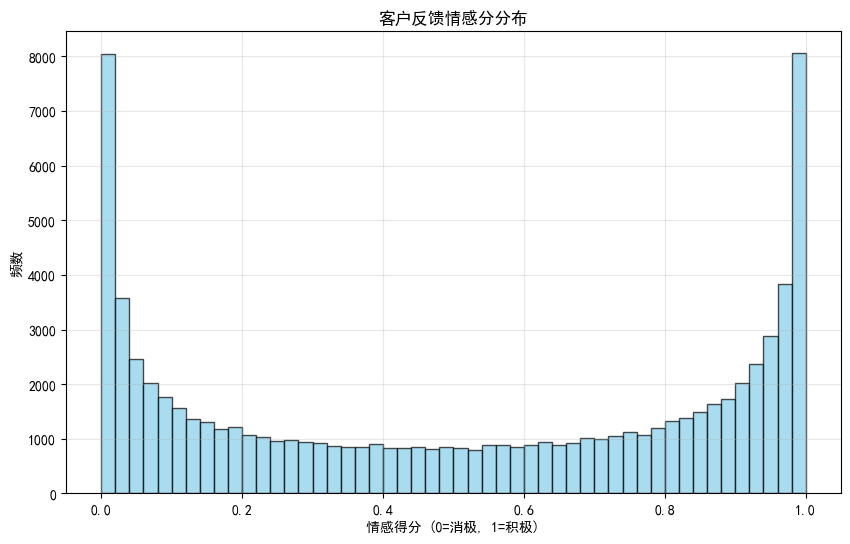

In [120]:
# 查看情感分布
plt.figure(figsize=(10, 6))
plt.hist(rent_train['客户反馈情感分'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('客户反馈情感分分布')
plt.xlabel('情感得分 (0=消极, 1=积极)')
plt.ylabel('频数')
plt.grid(True, alpha=0.3)
plt.show()

In [121]:
# 删除原始的特征列
columns_to_drop = ['楼层', '朝向', '交易时间', '建筑结构', '客户反馈']
rent_train = rent_train.drop(columns=columns_to_drop, errors='ignore')
rent_val = rent_val.drop(columns=columns_to_drop, errors='ignore')
test_rent = test_rent.drop(columns=columns_to_drop, errors='ignore')

In [122]:
check_missing_values(rent_train, "训练价格数据")

没有缺失值！


In [123]:
rent_train.head()

,Price,面积,lon,lat,年份,房屋总数,楼栋总数,绿 化 率,容 积 率,停车位,...,朝向_东北,朝向_西南,朝向_西北,交易年份,交易月份,建筑结构_板楼,建筑结构_塔楼,建筑结构_塔板结合,建筑结构_平房,客户反馈情感分
66850,3.132104e+05,40.16,115.284052,23.723170,2021.0,950.0,3.0,0.28,2.72,200.0,...,0,0,0,2024,5,0,0,1,0,0.831232
71707,9.174774e+05,88.00,115.105014,23.540701,2022.0,448.0,2.0,0.15,5.00,82.0,...,1,0,0,2024,8,0,0,1,0,0.816155
61913,1.001237e+06,132.00,114.582123,23.163062,2021.0,896.0,6.0,0.35,3.00,1033.0,...,0,0,0,2024,6,0,1,0,0,0.367587
35080,3.209228e+05,92.00,122.123757,32.304795,2021.0,2652.0,71.0,0.37,2.00,256.0,...,0,0,0,2024,6,1,0,0,0,0.236469
3691,7.232864e+05,42.12,117.369444,40.984551,2022.0,546.0,1.0,0.30,3.15,150.0,...,0,0,0,2024,7,1,0,0,0,0.022563


In [124]:
list(rent_train.columns)

['Price',
 '面积',
 'lon',
 'lat',
 '年份',
 '房屋总数',
 '楼栋总数',
 '绿 化 率',
 '容 积 率',
 '停车位',
 '付款方式_双月付价',
 '付款方式_季付价',
 '付款方式_年付价',
 '付款方式_月付价',
 '用水_民水',
 '用电_民电',
 '燃气_有',
 '租赁方式_整租',
 '电梯_有',
 '区县_5.0',
 '区县_7.0',
 '区县_9.0',
 '区县_10.0',
 '区县_11.0',
 '区县_12.0',
 '区县_13.0',
 '区县_14.0',
 '区县_15.0',
 '区县_16.0',
 '区县_17.0',
 '区县_19.0',
 '区县_20.0',
 '区县_21.0',
 '区县_22.0',
 '区县_23.0',
 '区县_24.0',
 '区县_26.0',
 '区县_28.0',
 '区县_29.0',
 '区县_30.0',
 '区县_32.0',
 '区县_33.0',
 '区县_34.0',
 '区县_35.0',
 '区县_36.0',
 '区县_37.0',
 '区县_38.0',
 '区县_41.0',
 '区县_42.0',
 '区县_43.0',
 '区县_44.0',
 '区县_45.0',
 '区县_47.0',
 '区县_48.0',
 '区县_49.0',
 '区县_50.0',
 '区县_51.0',
 '区县_52.0',
 '区县_53.0',
 '区县_54.0',
 '区县_56.0',
 '区县_57.0',
 '区县_58.0',
 '区县_59.0',
 '区县_60.0',
 '区县_62.0',
 '区县_63.0',
 '区县_64.0',
 '区县_65.0',
 '区县_66.0',
 '区县_67.0',
 '区县_68.0',
 '区县_69.0',
 '区县_70.0',
 '区县_71.0',
 '区县_72.0',
 '区县_76.0',
 '区县_77.0',
 '区县_78.0',
 '区县_80.0',
 '区县_81.0',
 '区县_82.0',
 '区县_84.0',
 '区县_85.0',
 '区县_86.0',
 '区县_88.0',
 '区县_89.0'

### 3、目标变量对数变换

In [125]:
# 创建对数变换后的新列，同时保留原始Price列
rent_train['Price_log'] = np.log1p(rent_train['Price'])
rent_val['Price_log'] = np.log1p(rent_val['Price'])

print(f"原始目标变量统计:")
print(f"  训练集: 均值={rent_train['Price'].mean():.2f}, 标准差={rent_train['Price'].std():.2f}")
print(f"  验证集: 均值={rent_val['Price'].mean():.2f}, 标准差={rent_val['Price'].std():.2f}")

print(f"对数变换后目标变量统计:")
print(f"  训练集: 均值={rent_train['Price_log'].mean():.2f}, 标准差={rent_train['Price_log'].std():.2f}")
print(f"  验证集: 均值={rent_val['Price_log'].mean():.2f}, 标准差={rent_val['Price_log'].std():.2f}")

原始目标变量统计:
  训练集: 均值=583173.62, 标准差=625031.90
  验证集: 均值=581888.79, 标准差=608981.20
对数变换后目标变量统计:
  训练集: 均值=12.96, 标准差=0.76
  验证集: 均值=12.96, 标准差=0.76


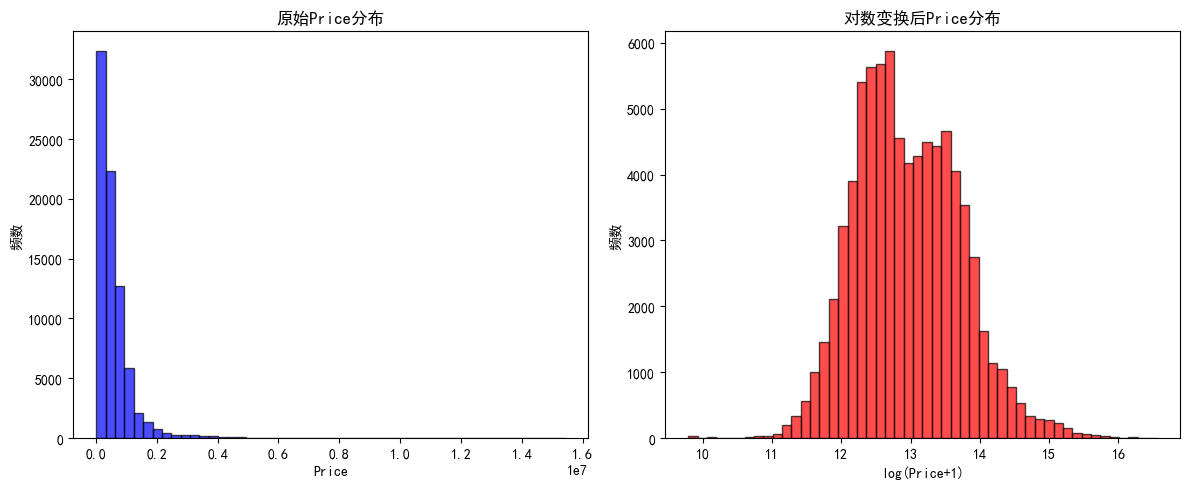

In [126]:
# 可视化对比
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(rent_train['Price'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('原始Price分布')
plt.xlabel('Price')
plt.ylabel('频数')

plt.subplot(1, 2, 2)
plt.hist(rent_train['Price_log'], bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('对数变换后Price分布')
plt.xlabel('log(Price+1)')
plt.ylabel('频数')

plt.tight_layout()
plt.show()

In [129]:
print(f"训练集形状: {rent_train.shape}")
print(f"验证集形状: {rent_val.shape}")
print(f"测试集形状: {test_rent.shape}")

训练集形状: (79115, 143)
验证集形状: (19780, 143)
测试集形状: (9773, 142)


# 四、建模

## (一) 房价预测

### 准备训练和验证数据

In [130]:
# 准备原始数据
def prepare_original_data(train_df, val_df, target_col='Price'):
    """准备原始训练和验证数据"""
    X_train = train_df.drop(columns=[target_col, 'Price_log'], errors='ignore')  # 排除Price_log
    y_train = train_df[target_col]
    X_val = val_df.drop(columns=[target_col, 'Price_log'], errors='ignore')  # 排除Price_log
    y_val = val_df[target_col]
    
    # 确保特征列一致
    common_cols = X_train.columns.intersection(X_val.columns)
    X_train = X_train[common_cols]
    X_val = X_val[common_cols]
    
    return X_train, X_val, y_train, y_val

In [131]:
# 准备原始房价数据（用于传统评估）
X_train_price, X_val_price, y_train_price, y_val_price = prepare_original_data(price_train, price_val)

print(f"原始数据训练集特征形状: {X_train_price.shape}")
print(f"原始数据验证集特征形状: {X_val_price.shape}")

原始数据训练集特征形状: (83096, 177)
原始数据验证集特征形状: (20775, 177)


In [132]:
# 准备对数变换数据
def prepare_log_data(train_df, val_df, target_col='Price_log'):
    """准备对数变换后的训练和验证数据"""
    X_train = train_df.drop(columns=['Price', target_col], errors='ignore')  # 排除原始Price
    y_train = train_df[target_col]
    X_val = val_df.drop(columns=['Price', target_col], errors='ignore')  # 排除原始Price
    y_val = val_df[target_col]
    
    # 确保特征列一致
    common_cols = X_train.columns.intersection(X_val.columns)
    X_train = X_train[common_cols]
    X_val = X_val[common_cols]
    
    return X_train, X_val, y_train, y_val

In [133]:
# 准备对数变换房价数据（用于对数模型）
X_train_price_log, X_val_price_log, y_train_price_log, y_val_price_log = prepare_log_data(price_train, price_val)

print(f"原始数据训练集特征形状: {X_train_price_log.shape}")
print(f"原始数据验证集特征形状: {X_val_price_log.shape}")

原始数据训练集特征形状: (83096, 177)
原始数据验证集特征形状: (20775, 177)


### 评估函数

In [134]:
def evaluate_model_log(model, X_train, X_val, y_train_log, y_val_log, model_name=""):
    """评估模型性能（针对对数变换的目标变量）- 所有指标都在原始尺度计算"""
    
    # 样本内预测（得到的是log(Price)的预测值）
    y_train_pred_log = model.predict(X_train)
    # 将预测值转换回原始尺度
    y_train_pred = np.expm1(y_train_pred_log)
    y_train_true = np.expm1(y_train_log)
    
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    
    # 样本外预测
    y_val_pred_log = model.predict(X_val)
    y_val_pred = np.expm1(y_val_pred_log)
    y_val_true = np.expm1(y_val_log)
    
    val_mae = mean_absolute_error(y_val_true, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
    
    # 6折交叉验证（在原始尺度上计算）
    def custom_scorer(estimator, X, y_log):
        """自定义评分函数，在原始尺度计算MAE"""
        y_pred_log = estimator.predict(X)
        y_pred = np.expm1(y_pred_log)
        y_true = np.expm1(y_log)
        return -mean_absolute_error(y_true, y_pred)  # 负号因为GridSearchCV最大化分数
    
    cv_scores_mae = -cross_val_score(model, X_train, y_train_log, 
                                   cv=6, scoring=custom_scorer)
    cv_mae = cv_scores_mae.mean()
    
    # 计算交叉验证的RMSE
    def custom_scorer_rmse(estimator, X, y_log):
        """自定义评分函数，在原始尺度计算RMSE"""
        y_pred_log = estimator.predict(X)
        y_pred = np.expm1(y_pred_log)
        y_true = np.expm1(y_log)
        return -np.sqrt(mean_squared_error(y_true, y_pred))
    
    cv_scores_rmse = -cross_val_score(model, X_train, y_train_log,
                                    cv=6, scoring=custom_scorer_rmse)
    cv_rmse = cv_scores_rmse.mean()
    
    results = {
        '模型': model_name,
        '样本内_MAE': train_mae,
        '样本外_MAE': val_mae,
        '交叉验证_MAE': cv_mae,
        '样本内_RMSE': train_rmse,
        '样本外_RMSE': val_rmse,
        '交叉验证_RMSE': cv_rmse
    }
    
    print(f"\n{model_name} 性能 (所有指标在原始尺度计算):")
    print(f"  样本内 MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f}")
    print(f"  样本外 MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}")
    print(f"  6折CV MAE: {cv_mae:.2f}, RMSE: {cv_rmse:.2f}")
    
    return results, y_val_pred

### 1、OLS线性回归

In [135]:
ols_price_model = LinearRegression()
ols_price_model.fit(X_train_price_log, y_train_price_log) 
ols_price_results, ols_price_pred = evaluate_model_log(ols_price_model, X_train_price_log, X_val_price_log, y_train_price_log, y_val_price_log, "OLS(房价)")


OLS(房价) 性能 (所有指标在原始尺度计算):
  样本内 MAE: 607527.82, RMSE: 2457146.79
  样本外 MAE: 572441.10, RMSE: 2090709.76
  6折CV MAE: 609769.42, RMSE: 2442508.78


### 2、Lasso回归

In [136]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(random_state=111), lasso_params, 
                         cv=6, scoring='neg_mean_absolute_error', n_jobs=-1)
lasso_grid.fit(X_train_price_log, y_train_price_log) 

print(f"Lasso 最佳参数: {lasso_grid.best_params_}")
lasso_price_model = lasso_grid.best_estimator_
lasso_price_results, lasso_price_pred = evaluate_model_log(lasso_price_model, X_train_price_log, X_val_price_log, y_train_price_log, y_val_price_log, "LASSO(房价)")

Lasso 最佳参数: {'alpha': 0.001}

LASSO(房价) 性能 (所有指标在原始尺度计算):
  样本内 MAE: 665657.77, RMSE: 2314395.18
  样本外 MAE: 634359.47, RMSE: 2135012.71
  6折CV MAE: 666906.25, RMSE: 2302291.09


### 3、Ridge回归

In [137]:
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_grid = GridSearchCV(Ridge(random_state=111), ridge_params, cv=6, scoring='neg_mean_absolute_error', n_jobs=-1)
ridge_grid.fit(X_train_price_log, y_train_price_log) 

print(f"Ridge 最佳参数: {ridge_grid.best_params_}")
ridge_price_model = ridge_grid.best_estimator_  
ridge_price_results, ridge_price_pred = evaluate_model_log(ridge_price_model, X_train_price_log, X_val_price_log, y_train_price_log, y_val_price_log, "Ridge(房价)")

Ridge 最佳参数: {'alpha': 0.001}

Ridge(房价) 性能 (所有指标在原始尺度计算):
  样本内 MAE: 607540.74, RMSE: 2456723.55
  样本外 MAE: 572476.17, RMSE: 2090753.76
  6折CV MAE: 609778.49, RMSE: 2441991.58


### 4、ElasticNet回归

In [138]:
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_grid = GridSearchCV(ElasticNet(random_state=111), elastic_params,
                           cv=6, scoring='neg_mean_absolute_error', n_jobs=-1)
elastic_grid.fit(X_train_price_log, y_train_price_log)

print(f"ElasticNet 最佳参数: {elastic_grid.best_params_}")
elastic_price_model = elastic_grid.best_estimator_
elastic_price_results, elastic_price_pred = evaluate_model_log(elastic_price_model, X_train_price_log, X_val_price_log, y_train_price_log, y_val_price_log, "ElasticNet(房价)")

ElasticNet 最佳参数: {'alpha': 0.001, 'l1_ratio': 0.1}

ElasticNet(房价) 性能 (所有指标在原始尺度计算):
  样本内 MAE: 635912.38, RMSE: 2359072.77
  样本外 MAE: 603200.61, RMSE: 2107806.06
  6折CV MAE: 637290.66, RMSE: 2342509.31


## (二) 租金预测

### 准备训练和验证数据

In [139]:
# 准备原始租金数据（用于传统评估）
X_train_rent, X_val_rent, y_train_rent, y_val_rent = prepare_original_data(rent_train, rent_val)

print(f"原始数据训练集特征形状: {X_train_rent.shape}")
print(f"原始数据验证集特征形状: {X_val_rent.shape}")

原始数据训练集特征形状: (79115, 139)
原始数据验证集特征形状: (19780, 139)


In [140]:
# 准备对数变换租金数据（用于对数模型）
X_train_rent_log, X_val_rent_log, y_train_rent_log, y_val_rent_log = prepare_log_data(rent_train, rent_val)

print(f"原始数据训练集特征形状: {X_train_rent_log.shape}")
print(f"原始数据验证集特征形状: {X_val_rent_log.shape}")

原始数据训练集特征形状: (79115, 139)
原始数据验证集特征形状: (19780, 139)


### 1、OLS线性回归

In [141]:
ols_rent_model = LinearRegression()
ols_rent_model.fit(X_train_rent_log, y_train_rent_log) 
ols_rent_results, ols_rent_pred = evaluate_model_log(ols_rent_model, X_train_rent_log, X_val_rent_log, y_train_rent_log, y_val_rent_log, "OLS(租金)")


OLS(租金) 性能 (所有指标在原始尺度计算):
  样本内 MAE: 127811.26, RMSE: 327284.42
  样本外 MAE: 127885.04, RMSE: 316708.85
  6折CV MAE: 128074.34, RMSE: 328160.99


### 2、Lasso回归

In [142]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid_rent = GridSearchCV(Lasso(random_state=111), lasso_params,
                              cv=6, scoring='neg_mean_absolute_error', n_jobs=-1)
lasso_grid_rent.fit(X_train_rent_log, y_train_rent_log)

print(f"Lasso 最佳参数: {lasso_grid.best_params_}")
lasso_rent_model = lasso_grid_rent.best_estimator_
lasso_rent_results, lasso_rent_pred = evaluate_model_log(lasso_rent_model, X_train_rent_log, X_val_rent_log, y_train_rent_log, y_val_rent_log, "LASSO(租金)")                       

Lasso 最佳参数: {'alpha': 0.001}

LASSO(租金) 性能 (所有指标在原始尺度计算):
  样本内 MAE: 138983.25, RMSE: 337596.67
  样本外 MAE: 139308.66, RMSE: 328561.42
  6折CV MAE: 139175.67, RMSE: 337916.65


### 3、Ridge回归

In [143]:
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_grid_rent = GridSearchCV(Ridge(random_state=111), ridge_params, cv=6, scoring='neg_mean_absolute_error', n_jobs=-1)  # 改名为 ridge_grid_rent
ridge_grid_rent.fit(X_train_rent_log, y_train_rent_log)

print(f"Ridge 最佳参数: {ridge_grid.best_params_}")
ridge_rent_model = ridge_grid_rent.best_estimator_
ridge_rent_results, ridge_rent_pred = evaluate_model_log(ridge_rent_model, X_train_rent_log, X_val_rent_log, y_train_rent_log, y_val_rent_log, "Ridge(租金)")

Ridge 最佳参数: {'alpha': 0.001}

Ridge(租金) 性能 (所有指标在原始尺度计算):
  样本内 MAE: 127799.57, RMSE: 327352.08
  样本外 MAE: 127951.17, RMSE: 316799.23
  6折CV MAE: 128061.48, RMSE: 328244.64


### 4、ElasticNet回归

In [144]:
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_grid_rent = GridSearchCV(ElasticNet(random_state=111), elastic_params,
                                cv=6, scoring='neg_mean_absolute_error', n_jobs=-1)
elastic_grid_rent.fit(X_train_rent_log, y_train_rent_log)

print(f"ElasticNet 最佳参数: {elastic_grid_rent.best_params_}")
elastic_rent_model = elastic_grid_rent.best_estimator_
elastic_rent_results, elastic_rent_pred = evaluate_model_log(elastic_rent_model, X_train_rent_log, X_val_rent_log, y_train_rent_log, y_val_rent_log, "ElasticNet(租金)")

ElasticNet 最佳参数: {'alpha': 0.001, 'l1_ratio': 0.1}

ElasticNet(租金) 性能 (所有指标在原始尺度计算):
  样本内 MAE: 132606.44, RMSE: 332704.56
  样本外 MAE: 132423.27, RMSE: 320372.51
  6折CV MAE: 132821.50, RMSE: 333351.29


# 五、测试集预测与输出

## 1、准备测试集数据

In [145]:
# 房价测试集 - 保留所有特征，包括ID
X_test_price = test_price.copy()

# 租金测试集 - 保留所有特征，包括ID  
X_test_rent = test_rent.copy()

print(f"房价测试集形状: {X_test_price.shape}")
print(f"租金测试集形状: {X_test_rent.shape}")

房价测试集形状: (34017, 190)
租金测试集形状: (9773, 142)


## 2、预测函数

In [146]:
def predict_and_save_combined_model(price_model, rent_model, model_name, 
                                   price_train_columns, rent_train_columns,
                                   test_price_df, test_rent_df, 
                                   output_folder="D:/360安全浏览器下载/predictions/"):
    """
    使用两个模型分别预测房价和租金，并合并保存结果
    """
    import os
    os.makedirs(output_folder, exist_ok=True)
    
    print(f"\n=== {model_name} 模型预测 ===")
    
    # 确保特征对齐函数
    def align_features(df, train_columns):
        """确保测试集特征与训练集特征对齐"""
        df_features = df.drop(columns=['ID'], errors='ignore')
        
        # 创建与训练集特征完全一致的DataFrame
        aligned_features = pd.DataFrame(0, index=df_features.index, columns=train_columns)
        
        # 填充存在的特征
        for col in train_columns:
            if col in df_features.columns:
                aligned_features[col] = df_features[col]
            else:
                print(f"警告: 特征 '{col}' 在测试集中不存在，使用0填充")
        
        return aligned_features
    
    # 对齐特征
    X_test_price_aligned = align_features(test_price_df, price_train_columns)
    X_test_rent_aligned = align_features(test_rent_df, rent_train_columns)
    
    print(f"房价测试集对齐后形状: {X_test_price_aligned.shape}")
    print(f"租金测试集对齐后形状: {X_test_rent_aligned.shape}")
    
    # 用房价模型预测房价（对数尺度）
    price_pred_log = price_model.predict(X_test_price_aligned)
    price_pred = np.expm1(price_pred_log)
    print(f"房价预测范围: {price_pred.min():.2f} - {price_pred.max():.2f}")
    
    # 用租金模型预测租金（对数尺度）
    rent_pred_log = rent_model.predict(X_test_rent_aligned)
    rent_pred = np.expm1(rent_pred_log)
    print(f"租金预测范围: {rent_pred.min():.2f} - {rent_pred.max():.2f}")
    
    # 直接从原始测试数据获取ID
    price_ids = test_price_df['ID']
    rent_ids = test_rent_df['ID']
    
    # 合并预测结果
    all_ids = list(price_ids) + list(rent_ids)
    all_prices = list(price_pred) + list(rent_pred)
    
    # 创建结果DataFrame
    result_df = pd.DataFrame({
        'ID': all_ids,
        'Price': all_prices
    })
    
    # 保存结果
    output_file = f"{output_folder}prediction_{model_name}.csv"
    result_df.to_csv(output_file, index=False)
    
    print(f"预测结果已保存到: {output_file}")
    print(f"总样本数: {len(result_df)} (房价: {len(price_pred)}, 租金: {len(rent_pred)})")
    print(f"结果预览:")
    print(result_df.head(10))
    
    return result_df

## 3、为每个模型生成预测结果

In [147]:
# 1. OLS模型预测
print("生成OLS模型预测结果")
ols_pred_result = predict_and_save_combined_model(ols_price_model, ols_rent_model, "OLS", 
                                                 X_train_price_log.columns, X_train_rent_log.columns,
                                                 X_test_price, X_test_rent)

生成OLS模型预测结果

=== OLS 模型预测 ===
警告: 特征 '区域_107.0' 在测试集中不存在，使用0填充
警告: 特征 '房屋用途_写字楼' 在测试集中不存在，使用0填充
警告: 特征 '房屋用途_底商' 在测试集中不存在，使用0填充
警告: 特征 '区县_19.0' 在测试集中不存在，使用0填充
房价测试集对齐后形状: (34017, 177)
租金测试集对齐后形状: (9773, 139)
房价预测范围: 96756.67 - 47777328.98
租金预测范围: 47141.12 - 15212683.68
预测结果已保存到: D:/360安全浏览器下载/predictions/prediction_OLS.csv
总样本数: 43790 (房价: 34017, 租金: 9773)
结果预览:
        ID         Price
0  1000000  4.405152e+07
1  1000001  2.815889e+06
2  1000002  5.167380e+06
3  1000003  3.611197e+06
4  1000004  8.536419e+06
5  1000005  2.545039e+06
6  1000006  1.639310e+07
7  1000007  2.977946e+06
8  1000008  4.232771e+06
9  1000009  1.227312e+07


In [148]:
# 2.Lasso模型预测
print("生成Lasso模型预测结果")
lasso_pred_result = predict_and_save_combined_model(lasso_price_model, lasso_rent_model, "Lasso", 
                                                   X_train_price_log.columns, X_train_rent_log.columns,
                                                   X_test_price, X_test_rent)

生成Lasso模型预测结果

=== Lasso 模型预测 ===
警告: 特征 '区域_107.0' 在测试集中不存在，使用0填充
警告: 特征 '房屋用途_写字楼' 在测试集中不存在，使用0填充
警告: 特征 '房屋用途_底商' 在测试集中不存在，使用0填充
警告: 特征 '区县_19.0' 在测试集中不存在，使用0填充
房价测试集对齐后形状: (34017, 177)
租金测试集对齐后形状: (9773, 139)
房价预测范围: 110641.03 - 46706905.46
租金预测范围: 67477.09 - 13410840.09
预测结果已保存到: D:/360安全浏览器下载/predictions/prediction_Lasso.csv
总样本数: 43790 (房价: 34017, 租金: 9773)
结果预览:
        ID         Price
0  1000000  3.583237e+07
1  1000001  2.298147e+06
2  1000002  5.035715e+06
3  1000003  2.649899e+06
4  1000004  8.753195e+06
5  1000005  1.296214e+06
6  1000006  1.521052e+07
7  1000007  3.033347e+06
8  1000008  3.994566e+06
9  1000009  9.417778e+06


In [149]:
# 3. Ridge模型预测
print("生成Ridge模型预测结果")
ridge_pred_result = predict_and_save_combined_model(ridge_price_model, ridge_rent_model, "Ridge", 
                                                   X_train_price_log.columns, X_train_rent_log.columns,
                                                   X_test_price, X_test_rent)

生成Ridge模型预测结果

=== Ridge 模型预测 ===
警告: 特征 '区域_107.0' 在测试集中不存在，使用0填充
警告: 特征 '房屋用途_写字楼' 在测试集中不存在，使用0填充
警告: 特征 '房屋用途_底商' 在测试集中不存在，使用0填充
警告: 特征 '区县_19.0' 在测试集中不存在，使用0填充
房价测试集对齐后形状: (34017, 177)
租金测试集对齐后形状: (9773, 139)
房价预测范围: 96762.19 - 47755807.05
租金预测范围: 47157.47 - 15151991.11
预测结果已保存到: D:/360安全浏览器下载/predictions/prediction_Ridge.csv
总样本数: 43790 (房价: 34017, 租金: 9773)
结果预览:
        ID         Price
0  1000000  4.405771e+07
1  1000001  2.815087e+06
2  1000002  5.168371e+06
3  1000003  3.607691e+06
4  1000004  8.536341e+06
5  1000005  2.545223e+06
6  1000006  1.639628e+07
7  1000007  2.977309e+06
8  1000008  4.235682e+06
9  1000009  1.227375e+07


In [150]:
# 4.ElasticNet模型预测
print("生成ElasticNet模型预测结果")
elastic_pred_result = predict_and_save_combined_model(elastic_price_model, elastic_rent_model, "ElasticNet", 
                                                     X_train_price_log.columns, X_train_rent_log.columns,
                                                     X_test_price, X_test_rent)

生成ElasticNet模型预测结果

=== ElasticNet 模型预测 ===
警告: 特征 '区域_107.0' 在测试集中不存在，使用0填充
警告: 特征 '房屋用途_写字楼' 在测试集中不存在，使用0填充
警告: 特征 '房屋用途_底商' 在测试集中不存在，使用0填充
警告: 特征 '区县_19.0' 在测试集中不存在，使用0填充
房价测试集对齐后形状: (34017, 177)
租金测试集对齐后形状: (9773, 139)
房价预测范围: 113120.18 - 42414586.42
租金预测范围: 65026.10 - 14244604.87
预测结果已保存到: D:/360安全浏览器下载/predictions/prediction_ElasticNet.csv
总样本数: 43790 (房价: 34017, 租金: 9773)
结果预览:
        ID         Price
0  1000000  3.523387e+07
1  1000001  2.428199e+06
2  1000002  5.205715e+06
3  1000003  2.778059e+06
4  1000004  8.569473e+06
5  1000005  1.959394e+06
6  1000006  1.531990e+07
7  1000007  3.044530e+06
8  1000008  4.193028e+06
9  1000009  9.407219e+06
